Coil force calculations for Next Step Fusion design
==========

Compute coil forces for limiting cases used in design paper.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
plt.rcParams['font.size']=16
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Shared setup

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
# sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk
from OpenFUSIONToolkit.util import mu0

In [3]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh_0801.h5')

### Initialize TokaMaker object

In [4]:
myOFT = OFT_env()
mygs = TokaMaker(myOFT)
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   string_len_def
Revision id:          9b25dc1
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                                                                                                                                                 
XML input file        = none                                                                                                                                                                                                    
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  6.143E+00
    # of points  =  

### Compute simple plasma distribution

Starting non-linear GS solver
     1  6.0276E+00  2.9094E+00  1.3426E-02  1.0307E+00  4.8252E-03 -0.0000E+00
     2  6.7847E+00  3.2645E+00  2.2278E-02  1.0319E+00  4.7646E-03 -0.0000E+00
     3  7.1594E+00  3.4411E+00  1.5393E-02  1.0324E+00  4.7510E-03 -0.0000E+00
     4  7.3459E+00  3.5295E+00  9.0532E-03  1.0326E+00  4.7541E-03 -0.0000E+00
     5  7.4413E+00  3.5750E+00  5.0491E-03  1.0326E+00  4.7621E-03 -0.0000E+00
     6  7.4907E+00  3.5986E+00  2.7564E-03  1.0327E+00  4.7698E-03 -0.0000E+00
     7  7.5164E+00  3.6109E+00  1.4872E-03  1.0327E+00  4.7759E-03 -0.0000E+00
     8  7.5298E+00  3.6174E+00  7.9576E-04  1.0327E+00  4.7802E-03 -0.0000E+00
     9  7.5369E+00  3.6208E+00  4.2488E-04  1.0327E+00  4.7830E-03 -0.0000E+00
    10  7.5407E+00  3.6226E+00  2.2632E-04  1.0327E+00  4.7848E-03 -0.0000E+00
    11  7.5426E+00  3.6236E+00  1.2051E-04  1.0327E+00  4.7859E-03 -0.0000E+00
    12  7.5437E+00  3.6241E+00  6.4177E-05  1.0327E+00  4.7866E-03 -0.0000E+00
    13  7.5443E+00  3.

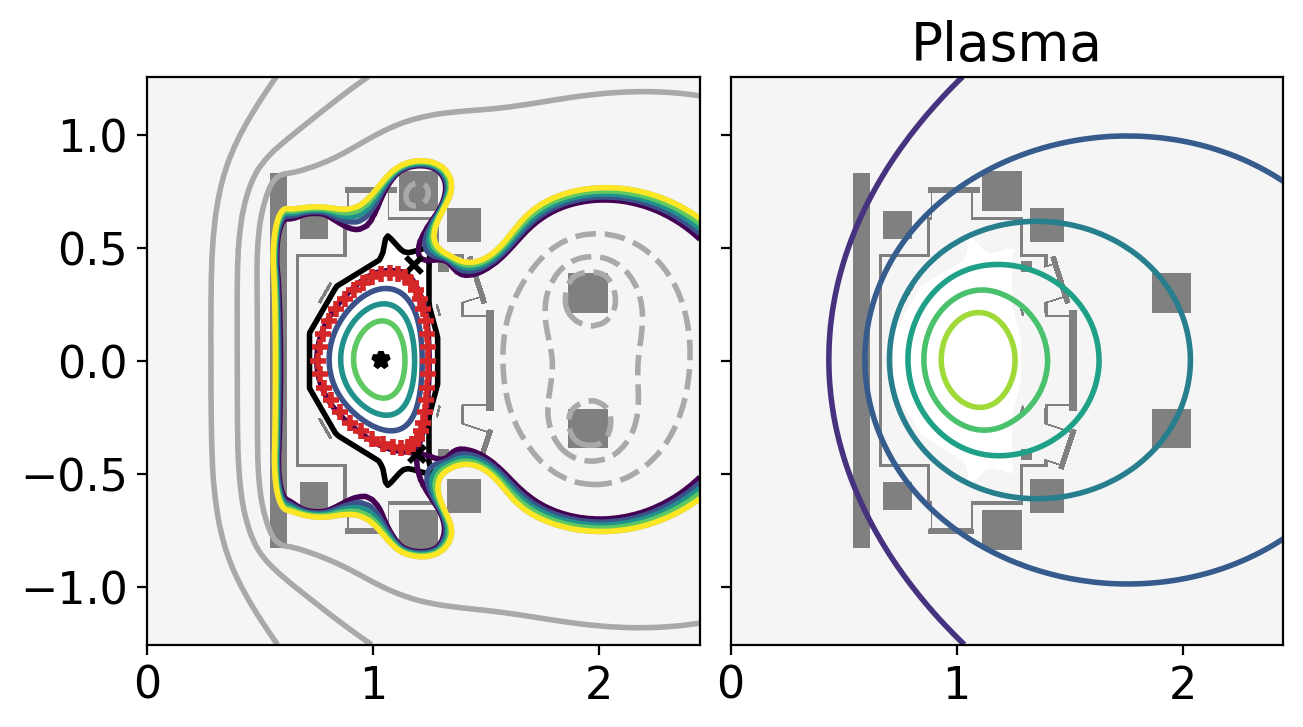

In [5]:
coil_regmat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-3*np.ones((mygs.ncoils+1,), dtype=np.float64)
coil_reg_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)

mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights,reg_targets=coil_reg_targets)

# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 1.25
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 1.25
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# set global targets
Ip_target = 1.0E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

boundary = create_isoflux(40,1.0,0.0,0.243,1.595,delta=-0.3,deltaL=-0.5)

isoflux_weights = 100*np.ones(len(boundary))
mygs.set_isoflux(boundary, isoflux_weights)

mygs.init_psi(0.68,0,0.2,1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()
psi_full = mygs.get_psi(normalized=False)

#plot equilibrium
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True)
mygs.plot_machine(fig,ax[0])#,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax[0],vacuum_nlevels=4,plasma_nlevels=5)
mygs.plot_constraints(fig,ax[0])

# Compute flux from coils only
mygs.set_psi(0.0*psi_full)
psi_vac, err_flag = mygs.vac_solve()
# Subtract to yield flux from plasma current
psi_plasma = psi_full-psi_vac

# Plot isolated plasma flux
mygs.plot_machine(fig,ax[1],limiter_color=None)
mygs.plot_psi(fig,ax[1],psi_plasma,normalized=False,xpoint_color=None,opoint_color=None)
_ = ax[1].set_title('Plasma')

### Load toroidal coil mesh for for calculations

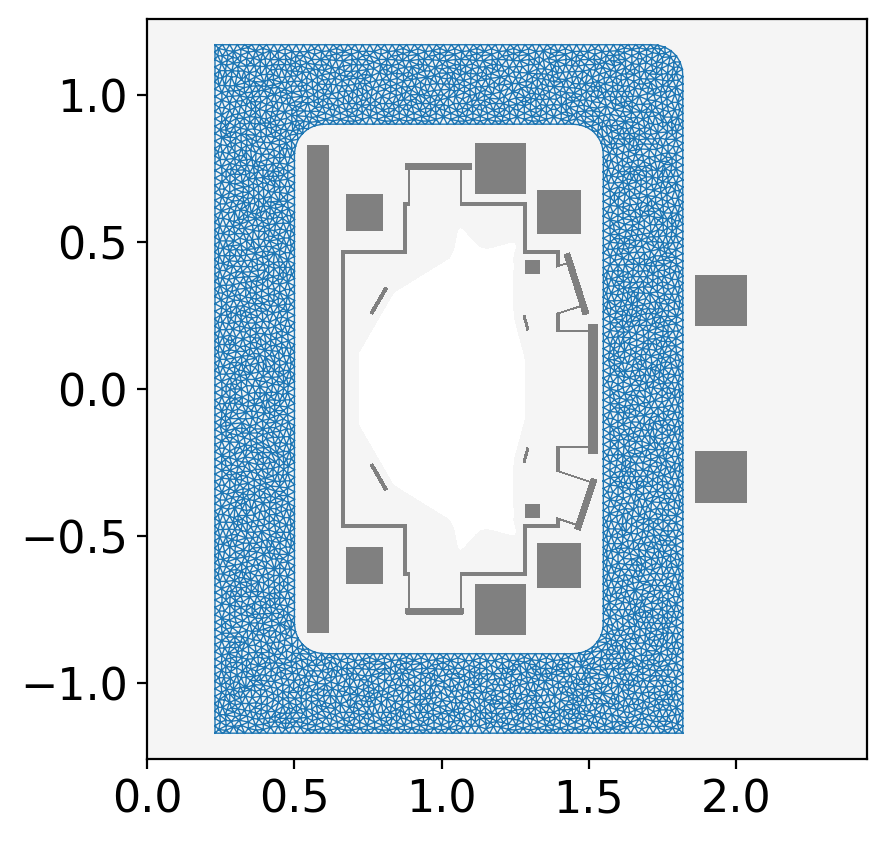

In [6]:
with open('TF_mesh.json', 'r') as fid:
    input_dict = json.load(fid)
tf_pts = np.array(input_dict['pts'])
tf_lc = np.array(input_dict['lc'])

# Plot mesh
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
_ = ax.triplot(tf_pts[:,0],tf_pts[:,1],tf_lc,lw=0.5)

### Setup approximate TF self-field and current density on TF coil grid

In [7]:
nTF = 16
inner_R0 = 0.260
outer_R0 = tf_pts[:,0].max()
leg_width = 0.270
bore = 1.050
height = 2.340
inner_radius = 0.100
leg_thickness = 0.190
TF_current = 3.0*313.E3
#
B_TF = np.zeros((tf_pts.shape[0],3))
J_TF = np.zeros((tf_pts.shape[0],3))
for i in range(tf_pts.shape[0]):
    if (abs(tf_pts[i,1]) > (height/2.0 - leg_width - inner_radius)) and abs(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0)) > (bore/2.0-inner_radius):
        if tf_pts[i,0] > 1.0:
            R0 = inner_R0+leg_width+bore-inner_radius
        else:
            R0 = inner_R0+leg_width+inner_radius
        Z0 = np.sign(tf_pts[i,1])*(height/2.0-leg_width-inner_radius)
        theta = np.arctan2(tf_pts[i,1]-Z0,tf_pts[i,0]-R0)
        J_TF[i,[0,2]] = [-np.sin(theta),np.cos(theta)]
    elif abs(tf_pts[i,1]) >= height/2.0 - leg_width - 0.01:
        J_TF[i,[0,2]] = [-np.sign(tf_pts[i,1]),0.0]
    else:
        J_TF[i,[0,2]] = [0.0,np.sign(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0))]
    # Set TF field
    if tf_pts[i,0] < inner_R0 or tf_pts[i,0] > outer_R0:
        B_TF[i,1] = 0.0
    else:
        B_TF[i,1] = max(0.0,min(1.0,(tf_pts[i,0]-inner_R0)/leg_width))*max(0.0,min(1.0,1.0-(tf_pts[i,0]-outer_R0)/leg_width))*mu0*nTF*TF_current/(tf_pts[i,0]*2.0*np.pi)
        if abs(tf_pts[i,1]) >= height/2.0 - leg_width - 0.01:
            B_TF[i,1] *= max(0.0,min(1.0,1.0-(abs(tf_pts[i,1])-(height/2.0 - leg_width))/leg_width))

J_TF *= TF_current/leg_width/leg_thickness

## Case 1 (TF loads figure)

   1  4.2410E+05


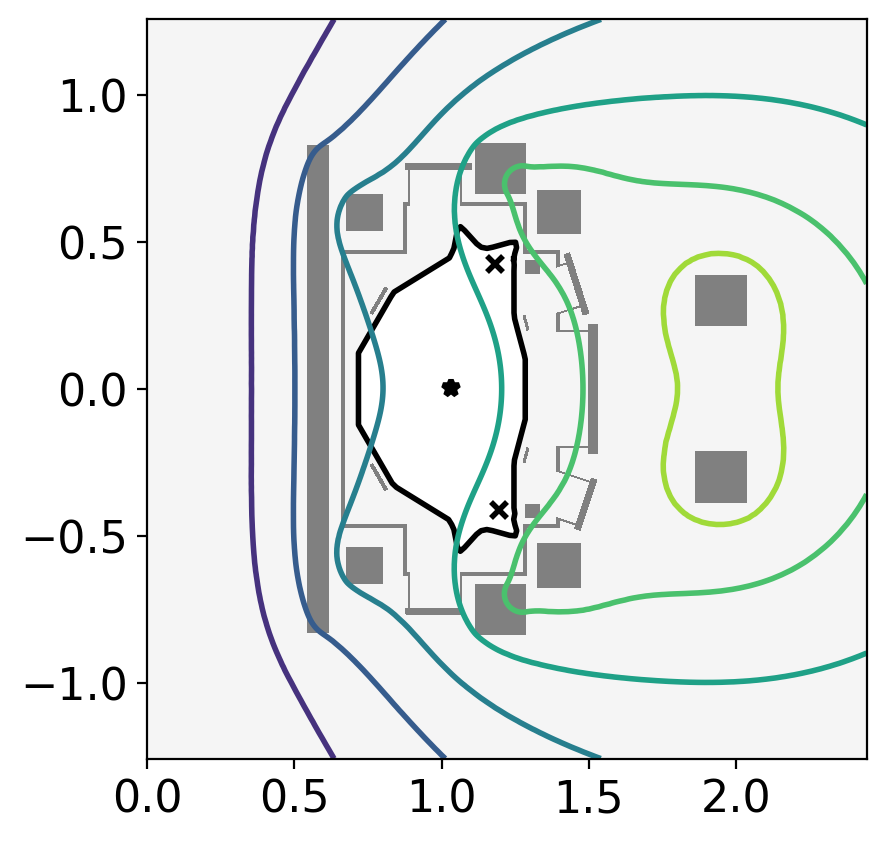

In [8]:
coil_currents = np.zeros((mygs.ncoils,), dtype=np.float64)

# CS coils
coil_currents[mygs.coil_sets['CS_1']['id']] = 3.5E6
coil_currents[mygs.coil_sets['CS_2']['id']] = 6E6
coil_currents[mygs.coil_sets['CS_3']['id']] = 3.5E6

# PF coils
coil_currents[mygs.coil_sets['PF_1U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_1L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_2U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_2L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_3U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_3L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_4U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_4L']['id']] = 1.5E6

mygs.set_coil_currents(coil_currents)
mygs.set_psi(0.0*mygs.get_psi())
psi_coil, __ = mygs.vac_solve()
mygs.set_psi(psi_coil-psi_plasma)
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax, normalized = False)

### Get poloidal field
Field is stored as \[B_r, B_phi, B_z\]

In [9]:
field_eval = mygs.get_field_eval('B')
for i in range(tf_pts.shape[0]):
    B_TF[i,[0,2]] = field_eval.eval(tf_pts[i,:])[[0,2]]

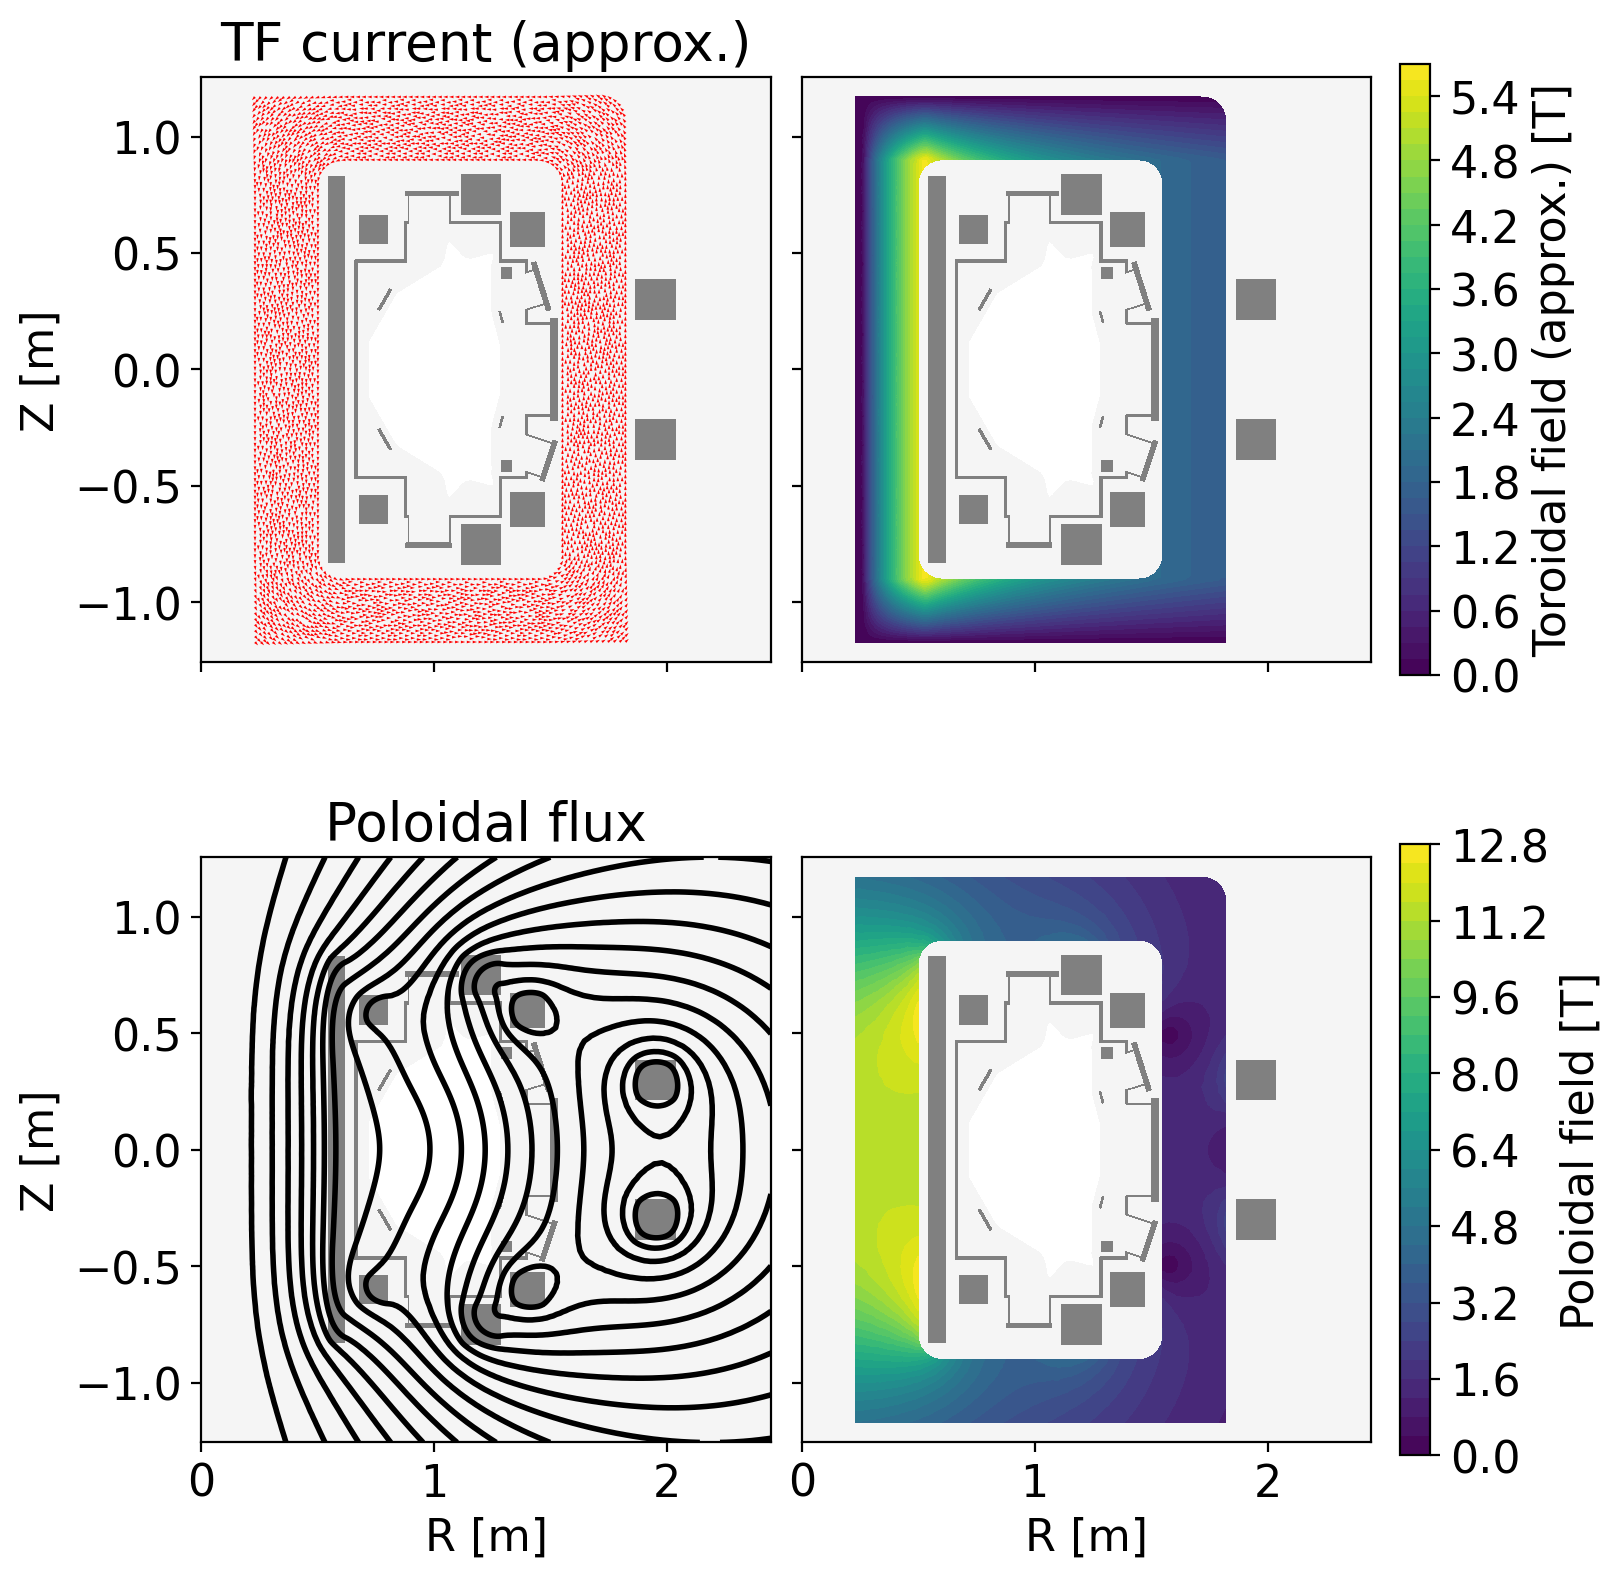

In [10]:
fig, ax = plt.subplots(2,2,sharey=True,sharex=True,figsize=(8,8),constrained_layout=True)
for ax_tmp in ax.flatten():
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
#
mygs.plot_psi(fig,ax[1,0],normalized=False,plasma_color='k',plasma_nlevels=20,opoint_color=None,xpoint_color=None)
ax[1,0].set_title('Poloidal flux')
clf = ax[1,1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,np.sqrt(np.power(B_TF[:,0],2)+np.power(B_TF[:,2],2)),40)
fig.colorbar(clf,ax=ax[1,1],label='Poloidal field [T]',shrink=0.8)
#
clf = ax[0,0].quiver(tf_pts[:,0],tf_pts[:,1],J_TF[:,0],J_TF[:,2],color='r')
ax[0,0].set_title('TF current (approx.)')
clf = ax[0,1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,1],40)
fig.colorbar(clf,ax=ax[0,1],label='Toroidal field (approx.) [T]',shrink=0.8)
#
ax[0,0].set_ylabel('Z [m]')
ax[1,0].set_ylabel('Z [m]')
ax[1,0].set_xlabel('R [m]')
_ = ax[1,1].set_xlabel('R [m]')

### Compute forces on TF coil (per coil)
Pressure is J_r * B_z * leg_thickness

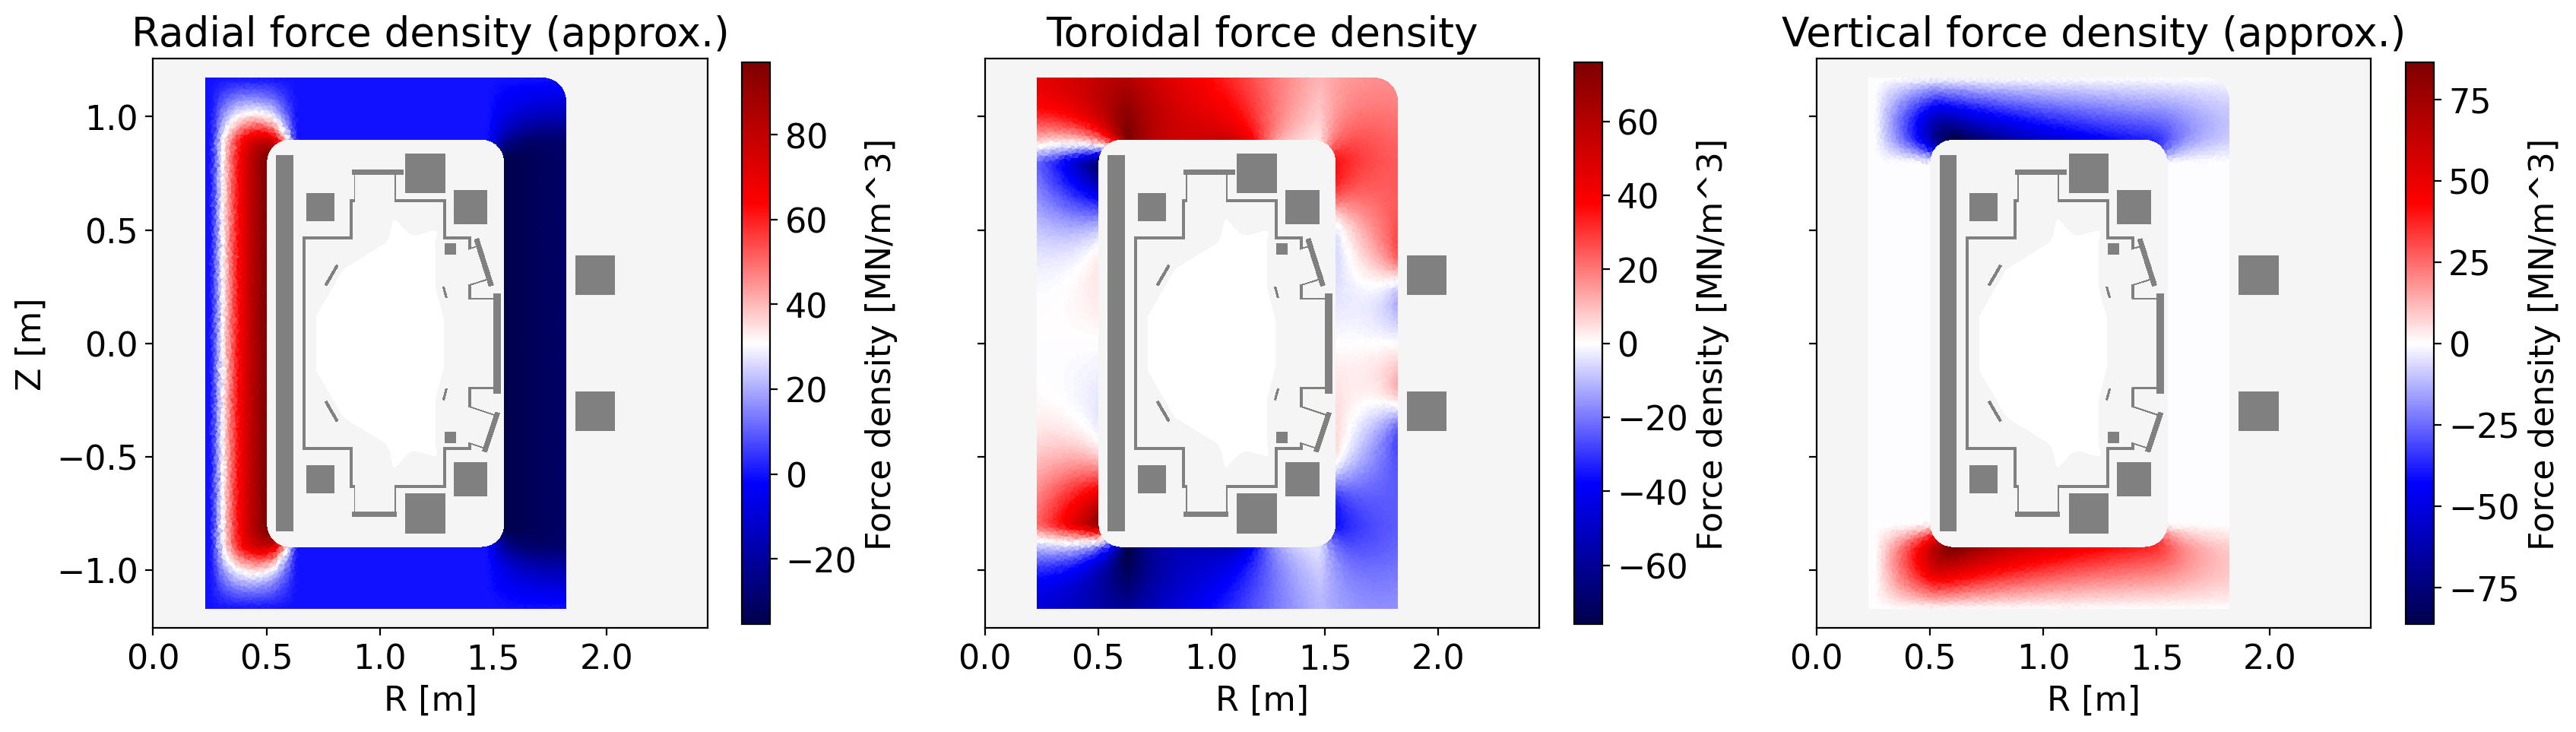

In [11]:
JxB = np.cross(J_TF,B_TF,axis=1)
# Radial
fig, ax = plt.subplots(1,3,sharey=True,figsize=(20,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R [m]')
clf = ax[0].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,0]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[0],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[0].set_title('Radial force density (approx.)')
# Toroidal force
clf = ax[1].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,1]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[1],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[1].set_title('Toroidal force density')
# Vertical
clf = ax[2].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,2]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[2],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[2].set_title('Vertical force density (approx.)')
_ = ax[0].set_ylabel('Z [m]')

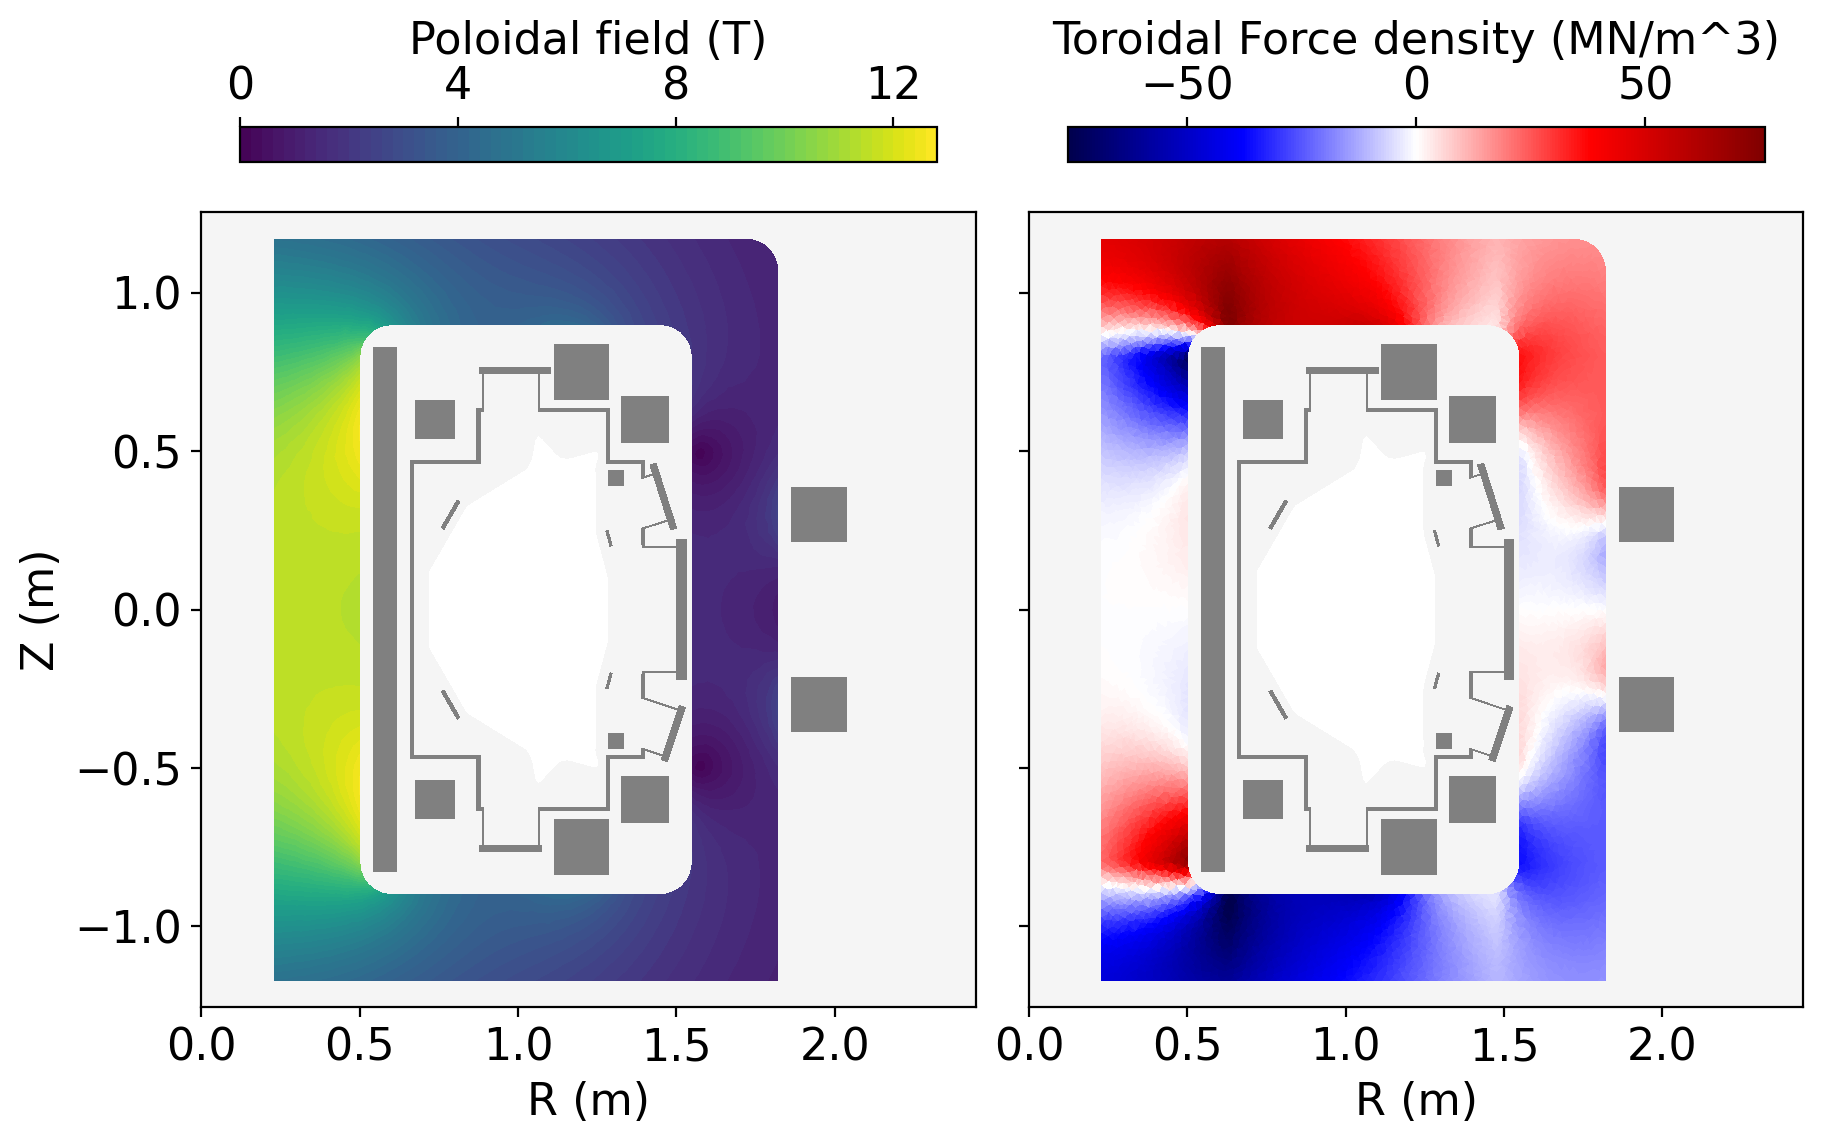

In [12]:
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(9,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R (m)')
#
clf = ax[0].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,np.sqrt(np.power(B_TF[:,0],2)+np.power(B_TF[:,2],2)),80)
fig.colorbar(clf,ax=ax[0],label='Poloidal field (T)',location='top',shrink=0.9,ticks=[0.0,4.0,8.0,12.0])
# Toroidal force
clf = ax[1].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,1]/1.E6,cmap='seismic')#,shading='gouraud')
_ = fig.colorbar(clf,ax=ax[1],label='Toroidal Force density (MN/m^3)',location='top',shrink=0.9)
_ = ax[0].set_ylabel('Z (m)')
fig.savefig('NTT_TF_forces.png',dpi=300)

As the force cancels if intergrated over the whole coil for an up-down symmetric field, the force on one half of the coil is reported.

In [13]:
overturning_force = 0.0
overturning_moment = 0.0
v1 = np.zeros((3,))
v2 = np.zeros((3,))
for i in range(tf_lc.shape[0]):
    v1[:-1] = tf_pts[tf_lc[i,1],:]-tf_pts[tf_lc[i,0],:]
    v2[:-1] = tf_pts[tf_lc[i,2],:]-tf_pts[tf_lc[i,0],:]
    area = np.linalg.norm(np.cross(v1,v2))/2.0
    rcc = (tf_pts[tf_lc[i,2],:]+tf_pts[tf_lc[i,1],:]+tf_pts[tf_lc[i,0],:])/3.0
    # Compute force on cell
    Favg = (JxB[tf_lc[i,2],1]+JxB[tf_lc[i,1],1]+JxB[tf_lc[i,0],1])/3.0
    overturning_force += np.sign(rcc[1])*area*Favg*leg_thickness
    overturning_moment += rcc[1]*area*Favg*leg_thickness
print('Overturning force per half coil = {0:10.2F} [kN] {1:10.2F} [T]'.format(abs(overturning_force)/2.0/1.E3,abs(overturning_force)/2.0*0.224809/2.E3))
print('Overturning moment per coil     = {0:10.2F} [kN-m]'.format(abs(overturning_moment)/1.E3))

Overturning force per half coil =    2884.93 [kN]     324.28 [T]
Overturning moment per coil     =    6009.76 [kN-m]


### Compute forces on PF coils

In [14]:
coil_currents, reg_currents = mygs.get_coil_currents()
B_PF = np.zeros((mesh_pts.shape[0],3))
F_PF = np.zeros((mesh_lc.shape[0],2))
F_PF[:] = np.nan
pt_mask = np.zeros((mesh_pts.shape[0],), dtype=np.int32)
for key, coil in coil_dict.items():
    pt_mask[mesh_lc[mesh_reg==coil['reg_id'],:]] = 1
for i in range(mesh_pts.shape[0]):
    if pt_mask[i] == 0:
        continue
    B_PF[i,:] = field_eval.eval(mesh_pts[i,:])
v1 = np.zeros((3,))
v2 = np.zeros((3,))
for key, coil in mygs.coil_sets.items():
    coil_area = 0.0
    coil_force = np.array([0.0,0.0])
    for subcoil in coil['sub_coils']:
        subcoil_area = 0.0
        nc = np.sum(mesh_reg==subcoil['reg_id'])
        Bcc = np.zeros((nc,3))
        for i, lc in enumerate(mesh_lc[mesh_reg==subcoil['reg_id'],:]):
            v1[:2] = mesh_pts[lc[1],:]-mesh_pts[lc[0],:]
            v2[:2] = mesh_pts[lc[2],:]-mesh_pts[lc[0],:]
            area = np.linalg.norm(np.cross(v1,v2))/2.0
            rcc = (mesh_pts[lc[2],:]+mesh_pts[lc[1],:]+mesh_pts[lc[0],:])/3.0
            Bcc[i,:] = (B_PF[lc[2],:]+B_PF[lc[1],:]+B_PF[lc[0],:])/3.0
            coil_force += Bcc[i,[2,0]]*reg_currents[subcoil['reg_id']-1]*area*2.0*np.pi*rcc[0]
            subcoil_area += area
        coil_area += subcoil_area
        Jtor_subcoil = coil_currents[coil['id']]*subcoil['nturns']/subcoil_area
        F_PF[mesh_reg==subcoil['reg_id'],0] = Bcc[:,2]*Jtor_subcoil
        F_PF[mesh_reg==subcoil['reg_id'],1] = -Bcc[:,0]*Jtor_subcoil
    coil_force /= coil_area
    print('{0:4} {1:14.4E} {2:14.4E}'.format(key,coil_force[0],-coil_force[1]))

CS_1     9.7839E+07    -2.7139E+07
CS_2     1.4638E+08    -5.3593E+04
CS_3     9.7919E+07     2.7173E+07
PF_1U     1.8384E+07    -8.6683E+06
PF_1L     1.8423E+07     8.7052E+06
PF_2U     2.7778E+07    -2.0472E+07
PF_2L     2.7765E+07     2.0487E+07
PF_3U     9.4316E+06    -3.5361E+06
PF_3L     9.4125E+06     3.5342E+06
PF_4U     1.7249E+06    -8.6131E+06
PF_4L     1.7230E+06     8.5995E+06
DIV_U     0.0000E+00    -0.0000E+00
DIV_L     0.0000E+00    -0.0000E+00


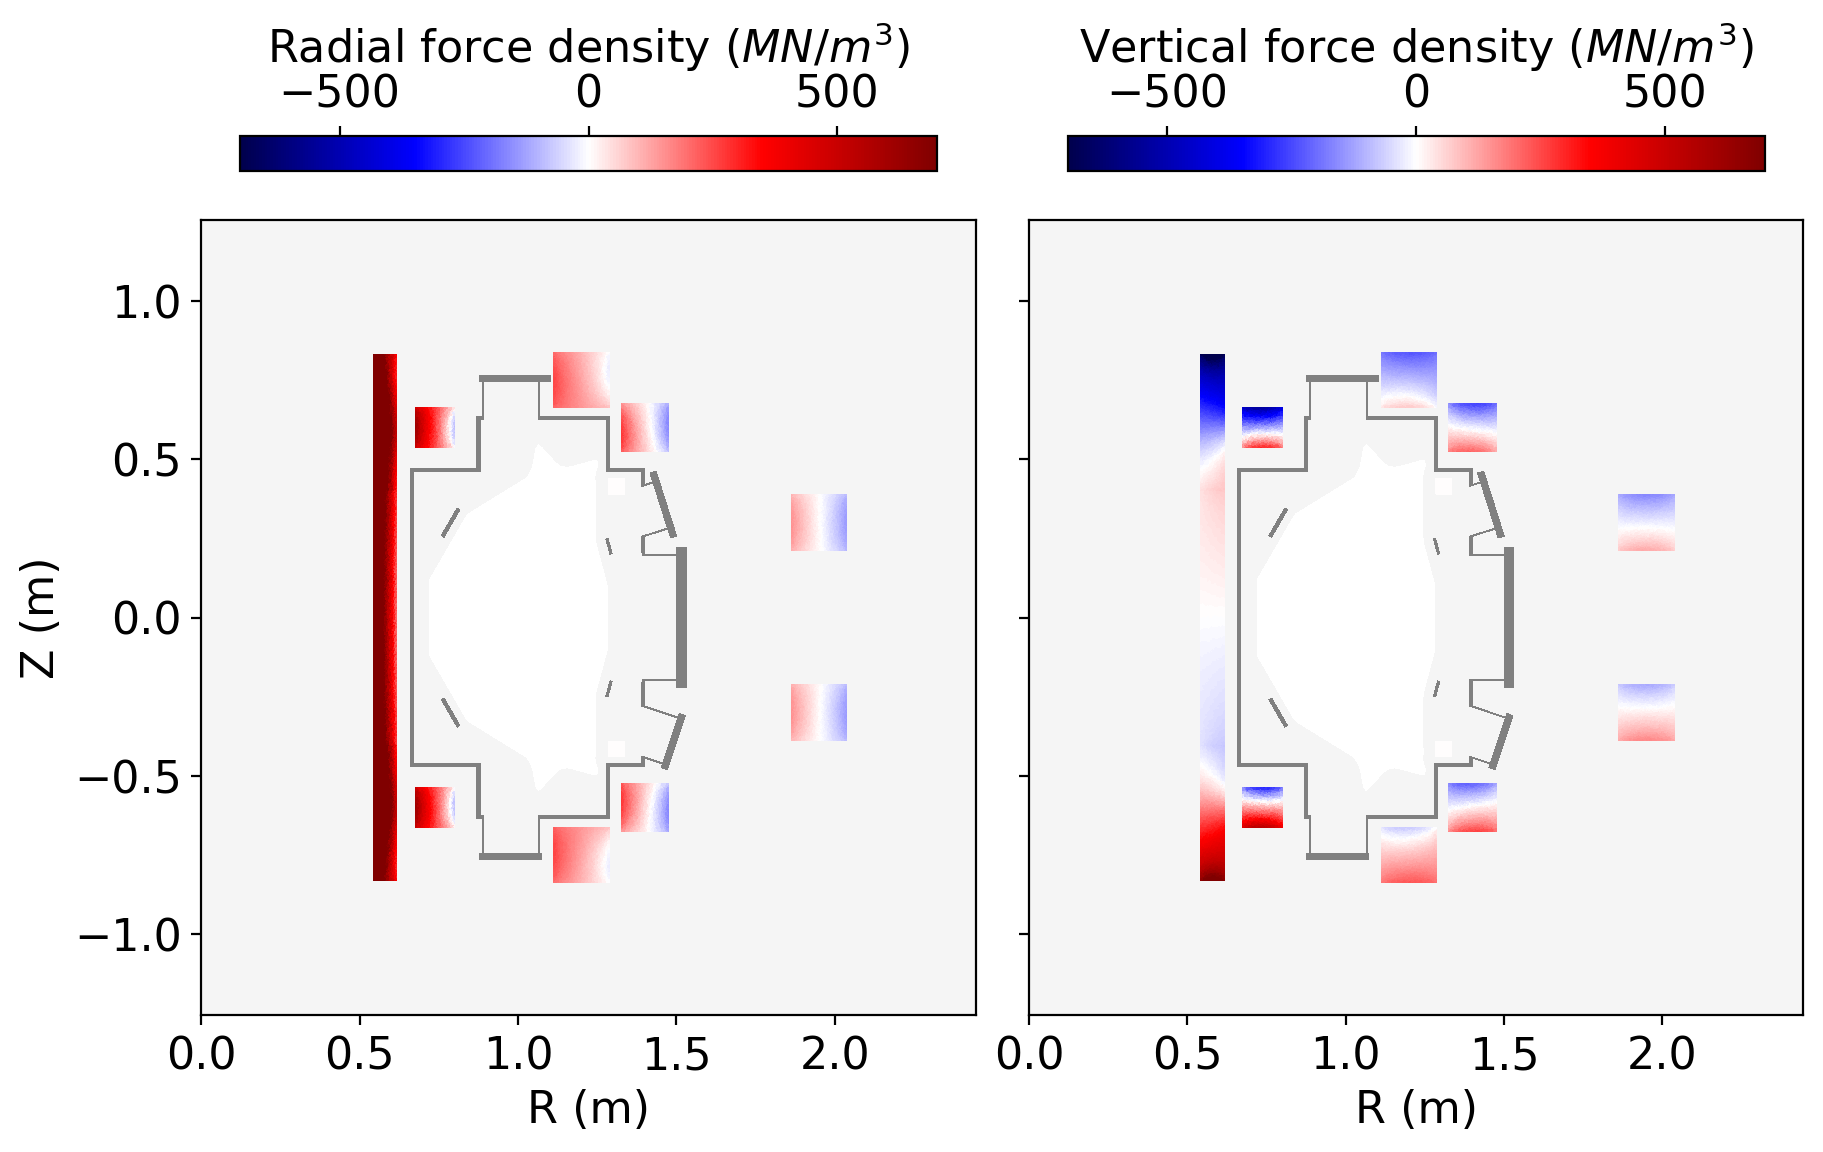

In [15]:
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(9,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R (m)')
#
clf = ax[0].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6,cmap='seismic',vmax=700,vmin=-700)#,vmax=300)
fig.colorbar(clf,ax=ax[0],label=r'Radial force density ($MN/m^3$)', location='top', shrink=0.9)
# Toroidal force
clf = ax[1].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6,cmap='seismic',vmax=700,vmin=-700)
fig.colorbar(clf,ax=ax[1],label=r'Vertical force density ($MN/m^3$)', location='top', shrink=0.9)
_ = ax[0].set_ylabel('Z (m)')

## Case 2 (PF loads figure)

   1  1.4695E+05


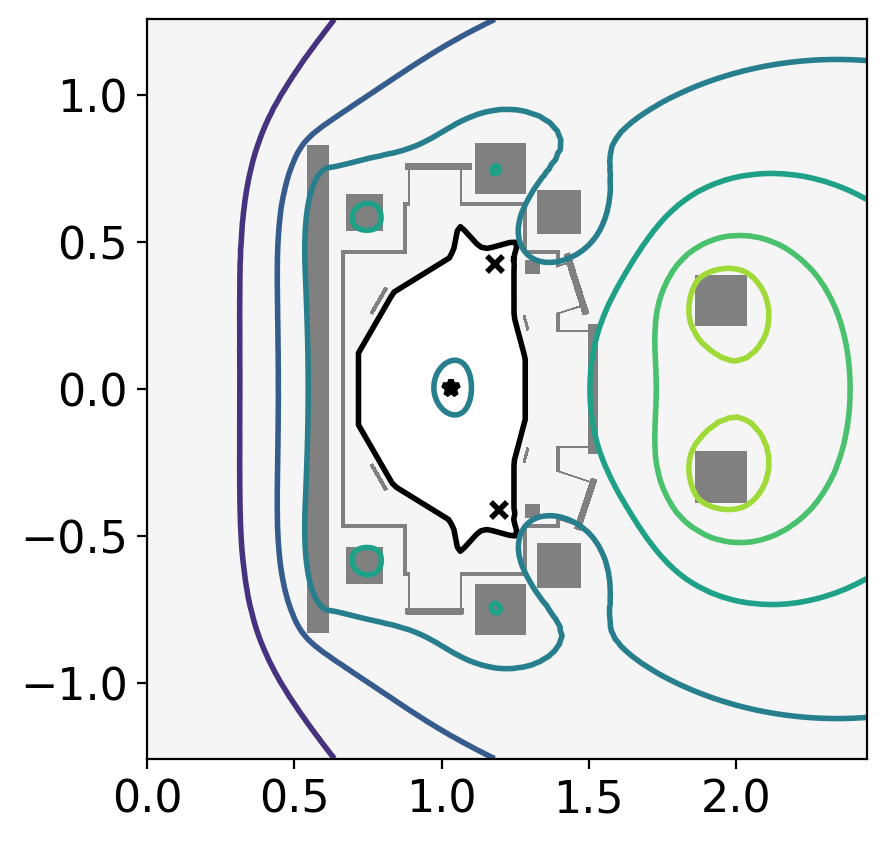

In [16]:
coil_currents = np.zeros((mygs.ncoils,), dtype=np.float64)

# CS coils
coil_currents[mygs.coil_sets['CS_1']['id']] = 3.5E6
coil_currents[mygs.coil_sets['CS_2']['id']] = 6E6
coil_currents[mygs.coil_sets['CS_3']['id']] = 3.5E6

# PF coils
coil_currents[mygs.coil_sets['PF_1U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_1L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_2U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_2L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_3U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_3L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_4U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_4L']['id']] = 1.5E6

# Case 2: PF3 is in opposite direction
coil_currents[mygs.coil_sets['PF_3U']['id']] = -1.5E6
coil_currents[mygs.coil_sets['PF_3L']['id']] = -1.5E6

mygs.set_coil_currents(coil_currents)
mygs.set_psi(0.0*mygs.get_psi())
psi_coil, __ = mygs.vac_solve()
mygs.set_psi(psi_coil-psi_plasma)
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax, normalized = False)

### Get poloidal field
Field is stored as \[B_r, B_phi, B_z\]

In [17]:
field_eval = mygs.get_field_eval('B')
for i in range(tf_pts.shape[0]):
    B_TF[i,[0,2]] = field_eval.eval(tf_pts[i,:])[[0,2]]

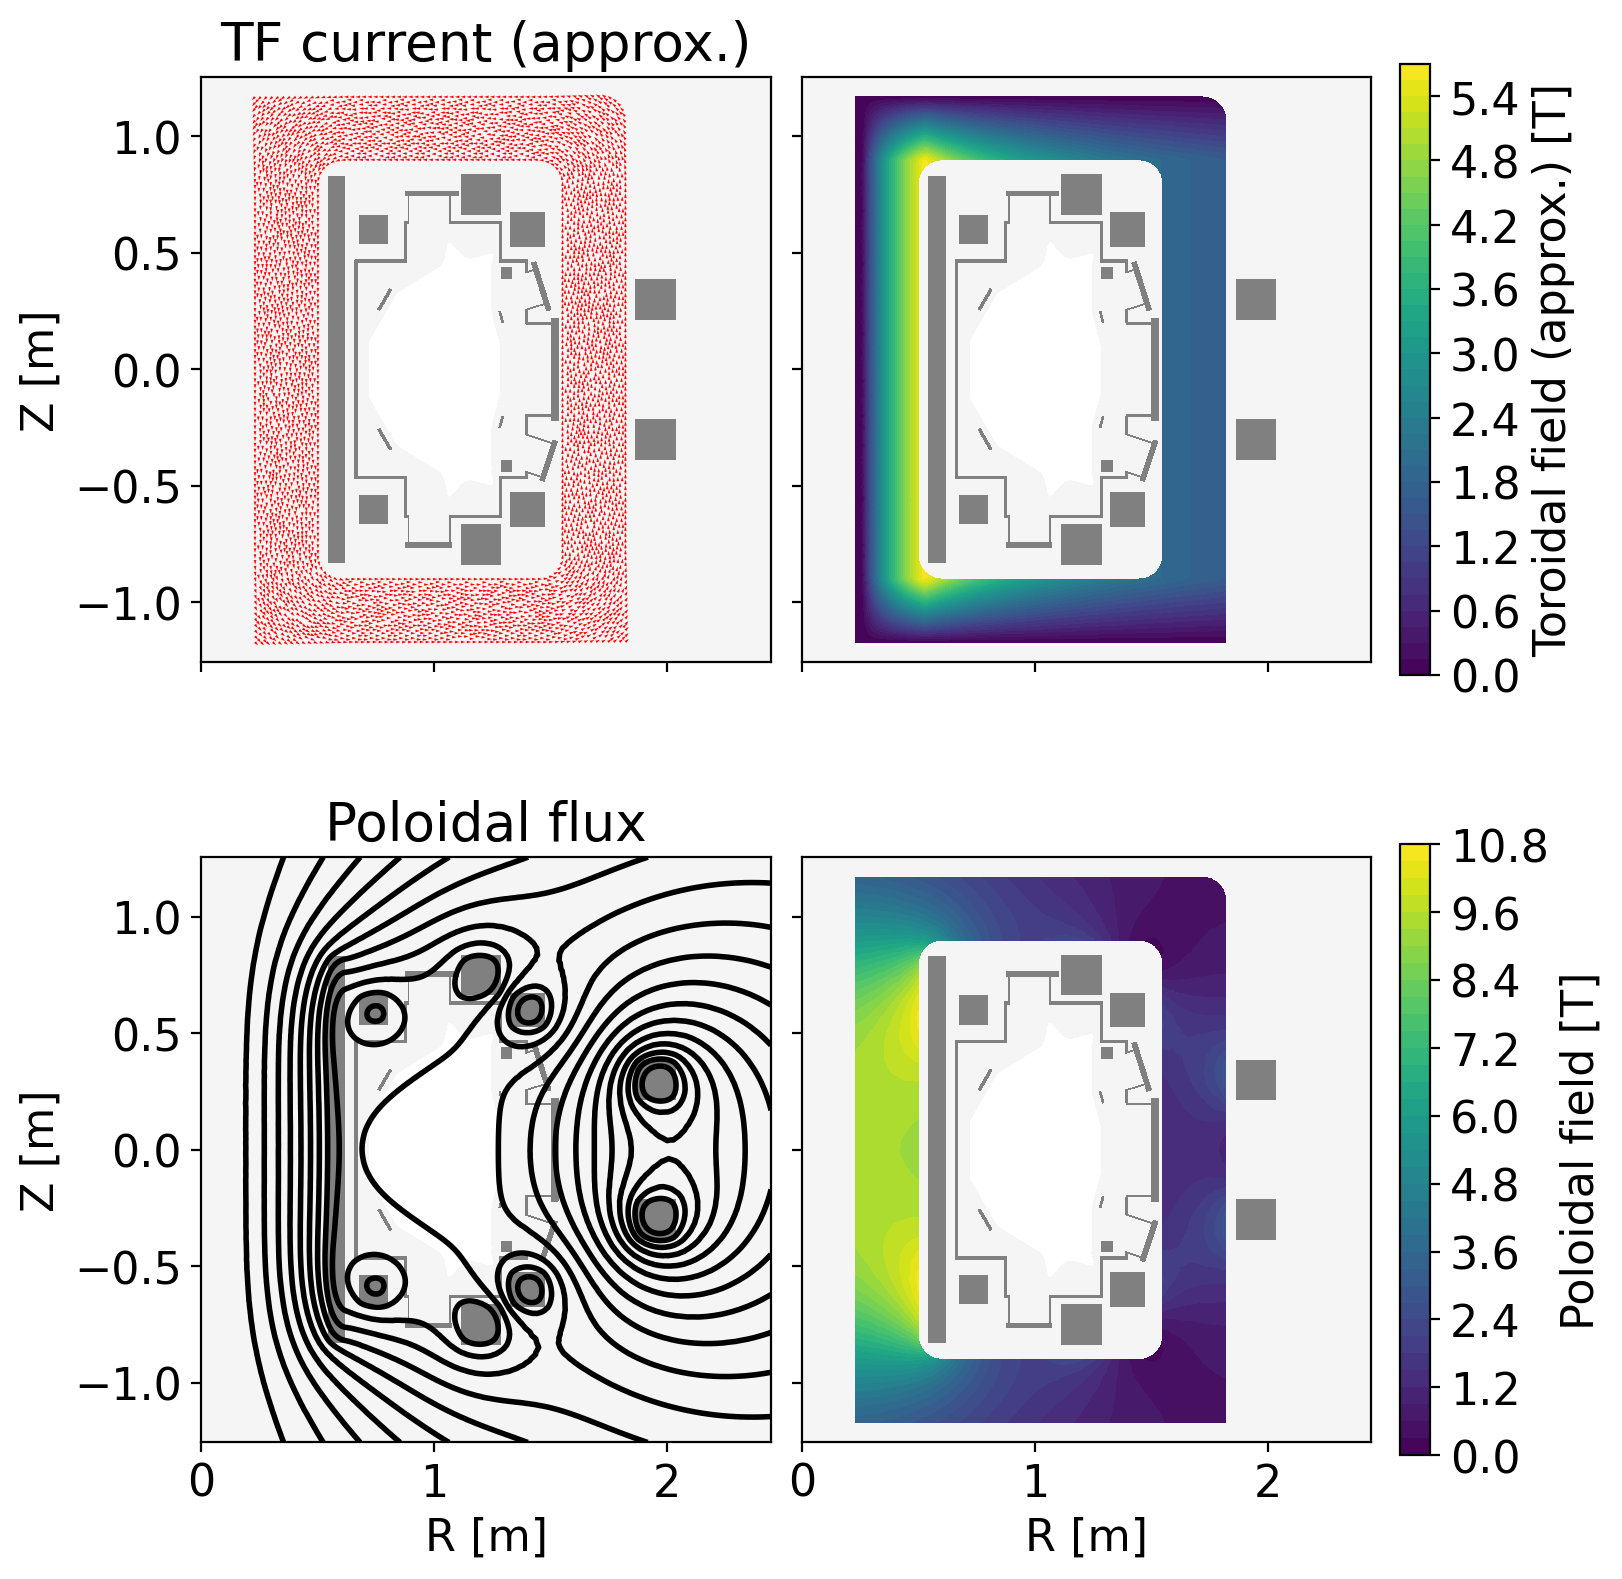

In [18]:
fig, ax = plt.subplots(2,2,sharey=True,sharex=True,figsize=(8,8),constrained_layout=True)
for ax_tmp in ax.flatten():
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
#
mygs.plot_psi(fig,ax[1,0],normalized=False,plasma_color='k',plasma_nlevels=20,opoint_color=None,xpoint_color=None)
ax[1,0].set_title('Poloidal flux')
clf = ax[1,1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,np.sqrt(np.power(B_TF[:,0],2)+np.power(B_TF[:,2],2)),40)
fig.colorbar(clf,ax=ax[1,1],label='Poloidal field [T]',shrink=0.8)
#
clf = ax[0,0].quiver(tf_pts[:,0],tf_pts[:,1],J_TF[:,0],J_TF[:,2],color='r')
ax[0,0].set_title('TF current (approx.)')
clf = ax[0,1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,1],40)
fig.colorbar(clf,ax=ax[0,1],label='Toroidal field (approx.) [T]',shrink=0.8)
#
ax[0,0].set_ylabel('Z [m]')
ax[1,0].set_ylabel('Z [m]')
ax[1,0].set_xlabel('R [m]')
_ = ax[1,1].set_xlabel('R [m]')

### Compute forces on TF coil (per coil)
Pressure is J_r * B_z * leg_thickness

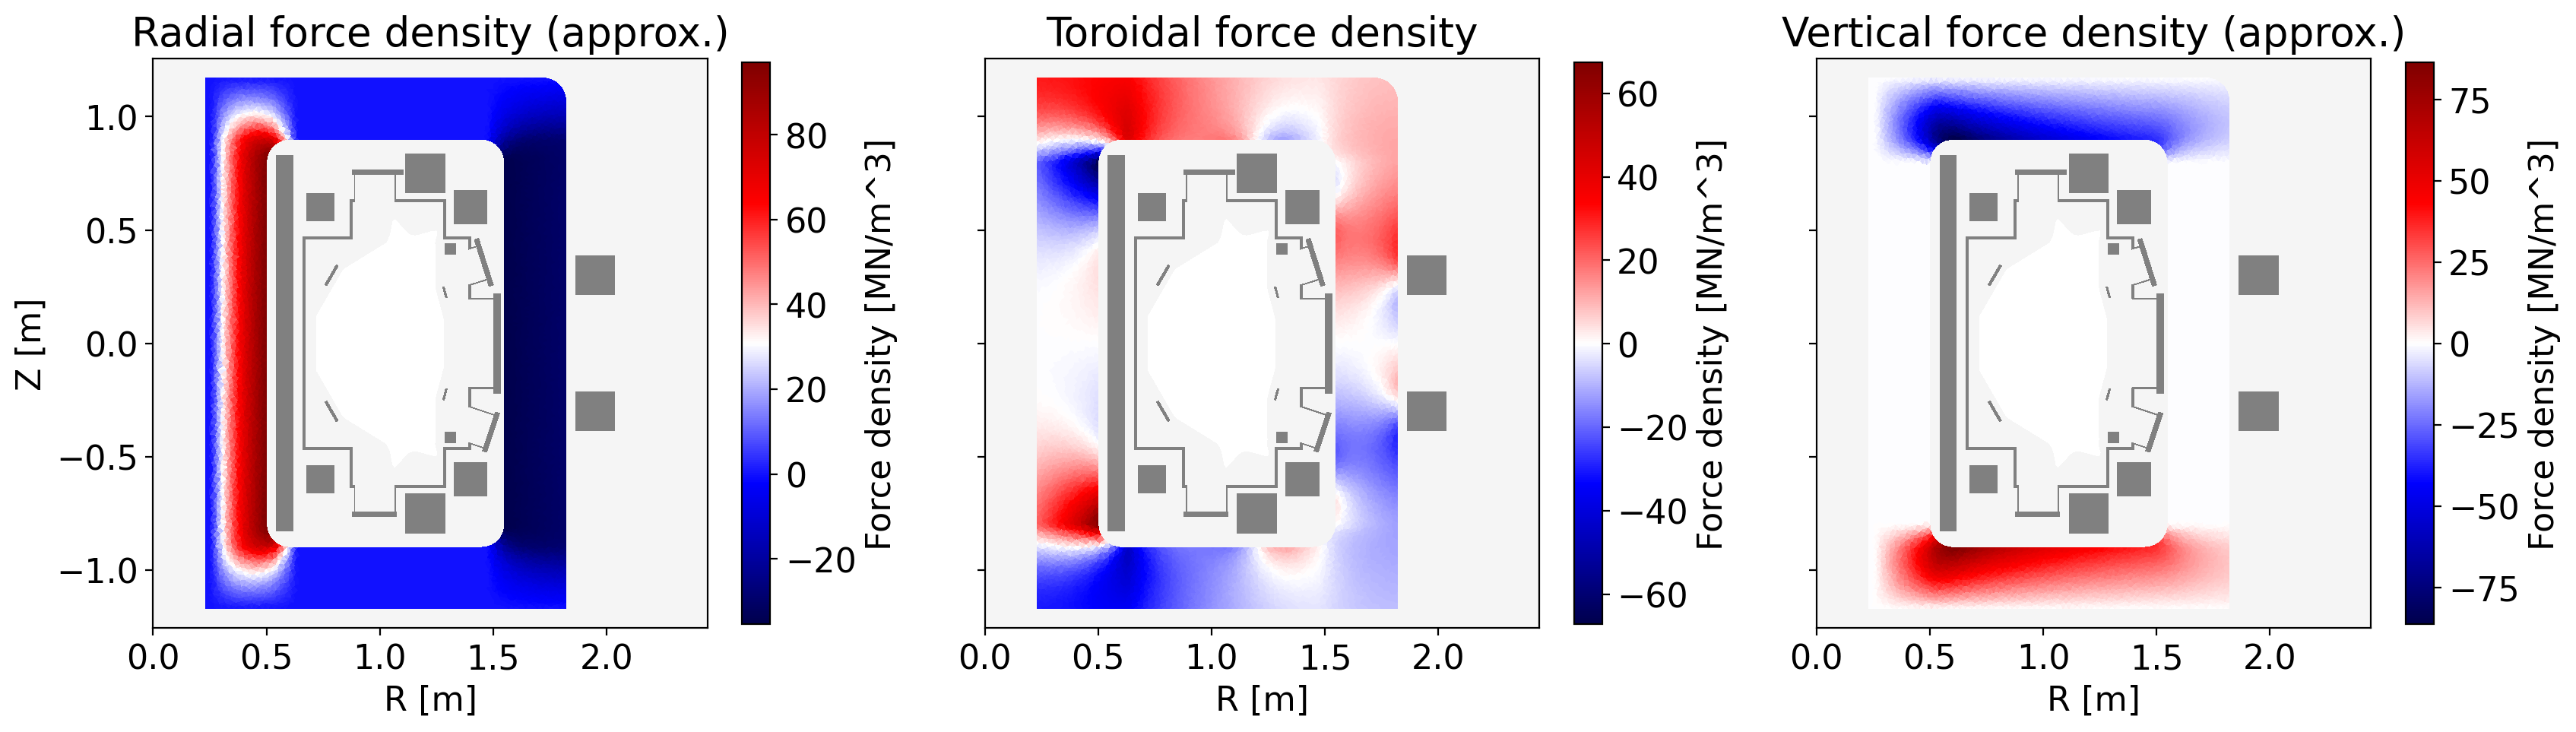

In [19]:
JxB = np.cross(J_TF,B_TF,axis=1)
# Radial
fig, ax = plt.subplots(1,3,sharey=True,figsize=(20,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R [m]')
clf = ax[0].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,0]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[0],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[0].set_title('Radial force density (approx.)')
# Toroidal force
clf = ax[1].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,1]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[1],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[1].set_title('Toroidal force density')
# Vertical
clf = ax[2].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,2]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[2],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[2].set_title('Vertical force density (approx.)')
_ = ax[0].set_ylabel('Z [m]')

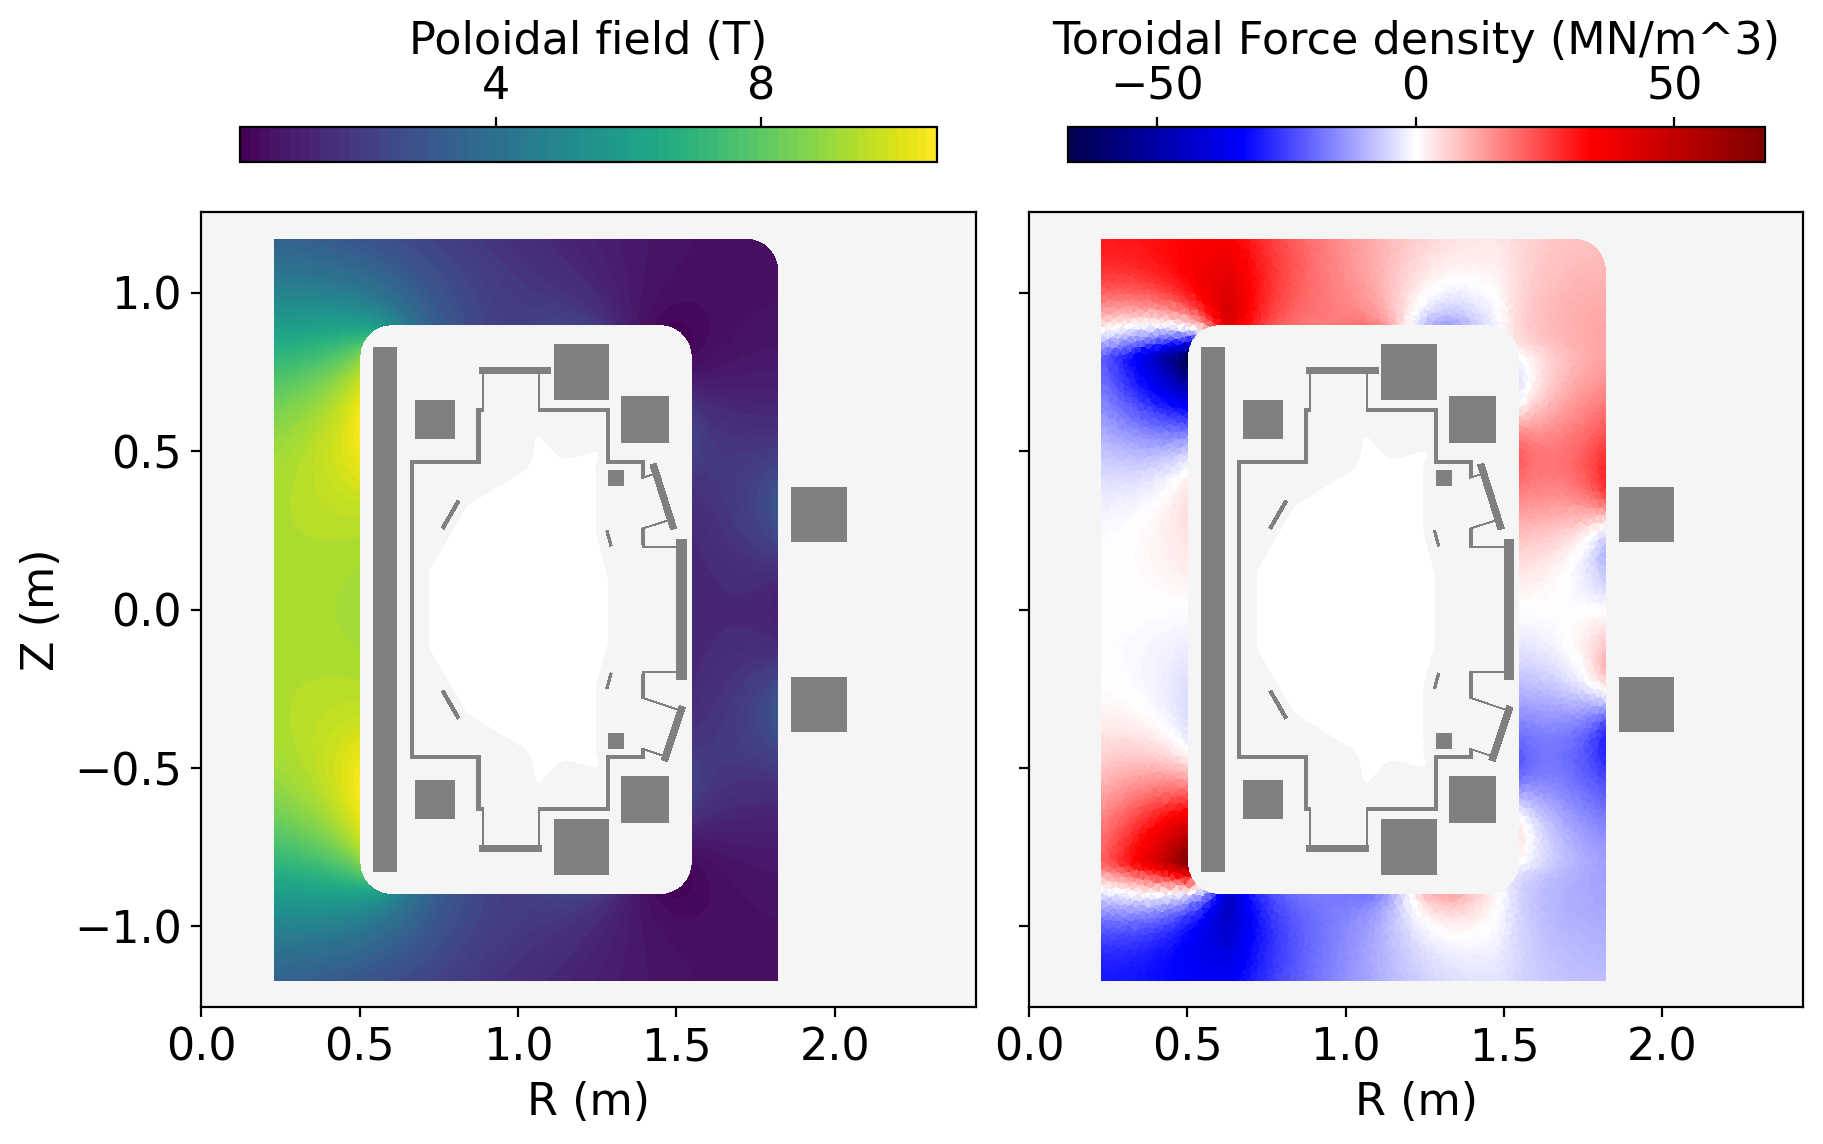

In [20]:
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(9,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R (m)')
#
clf = ax[0].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,np.sqrt(np.power(B_TF[:,0],2)+np.power(B_TF[:,2],2)),80)
fig.colorbar(clf,ax=ax[0],label='Poloidal field (T)',location='top',shrink=0.9,ticks=[0.0,4.0,8.0,12.0])
# Toroidal force
clf = ax[1].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,1]/1.E6,cmap='seismic')#,shading='gouraud')
_ = fig.colorbar(clf,ax=ax[1],label='Toroidal Force density (MN/m^3)',location='top',shrink=0.9)
_ = ax[0].set_ylabel('Z (m)')

In [21]:
overturning_force = 0.0
overturning_moment = 0.0
v1 = np.zeros((3,))
v2 = np.zeros((3,))
for i in range(tf_lc.shape[0]):
    v1[:-1] = tf_pts[tf_lc[i,1],:]-tf_pts[tf_lc[i,0],:]
    v2[:-1] = tf_pts[tf_lc[i,2],:]-tf_pts[tf_lc[i,0],:]
    area = np.linalg.norm(np.cross(v1,v2))/2.0
    rcc = (tf_pts[tf_lc[i,2],:]+tf_pts[tf_lc[i,1],:]+tf_pts[tf_lc[i,0],:])/3.0
    # Compute force on cell
    Favg = (JxB[tf_lc[i,2],1]+JxB[tf_lc[i,1],1]+JxB[tf_lc[i,0],1])/3.0
    overturning_force += np.sign(rcc[1])*area*Favg*leg_thickness
    overturning_moment += rcc[1]*area*Favg*leg_thickness
print('Overturning force per half coil = {0:10.2F} [kN] {1:10.2F} [T]'.format(abs(overturning_force)/2.0/1.E3,abs(overturning_force)/2.0*0.224809/2.E3))
print('Overturning moment per coil     = {0:10.2F} [kN-m]'.format(abs(overturning_moment)/1.E3))

Overturning force per half coil =    1215.79 [kN]     136.66 [T]
Overturning moment per coil     =    2416.91 [kN-m]


### Compute forces on PF coils

In [22]:
coil_currents, reg_currents = mygs.get_coil_currents()
B_PF = np.zeros((mesh_pts.shape[0],3))
F_PF = np.zeros((mesh_lc.shape[0],2))
F_PF[:] = np.nan
pt_mask = np.zeros((mesh_pts.shape[0],), dtype=np.int32)
for key, coil in coil_dict.items():
    pt_mask[mesh_lc[mesh_reg==coil['reg_id'],:]] = 1
for i in range(mesh_pts.shape[0]):
    if pt_mask[i] == 0:
        continue
    B_PF[i,:] = field_eval.eval(mesh_pts[i,:])
v1 = np.zeros((3,))
v2 = np.zeros((3,))
for key, coil in mygs.coil_sets.items():
    coil_area = 0.0
    coil_force = np.array([0.0,0.0])
    for subcoil in coil['sub_coils']:
        subcoil_area = 0.0
        nc = np.sum(mesh_reg==subcoil['reg_id'])
        Bcc = np.zeros((nc,3))
        for i, lc in enumerate(mesh_lc[mesh_reg==subcoil['reg_id'],:]):
            v1[:2] = mesh_pts[lc[1],:]-mesh_pts[lc[0],:]
            v2[:2] = mesh_pts[lc[2],:]-mesh_pts[lc[0],:]
            area = np.linalg.norm(np.cross(v1,v2))/2.0
            rcc = (mesh_pts[lc[2],:]+mesh_pts[lc[1],:]+mesh_pts[lc[0],:])/3.0
            Bcc[i,:] = (B_PF[lc[2],:]+B_PF[lc[1],:]+B_PF[lc[0],:])/3.0
            coil_force += Bcc[i,[2,0]]*reg_currents[subcoil['reg_id']-1]*area*2.0*np.pi*rcc[0]
            subcoil_area += area
        coil_area += subcoil_area
        Jtor_subcoil = coil_currents[coil['id']]*subcoil['nturns']/subcoil_area
        F_PF[mesh_reg==subcoil['reg_id'],0] = Bcc[:,2]*Jtor_subcoil
        F_PF[mesh_reg==subcoil['reg_id'],1] = -Bcc[:,0]*Jtor_subcoil
    coil_force /= coil_area
    print('{0:4} {1:14.4E} {2:14.4E}'.format(key,coil_force[0],-coil_force[1]))

CS_1     7.1629E+07    -2.4723E+07
CS_2     9.9754E+07    -5.3359E+04
CS_3     7.1709E+07     2.4758E+07
PF_1U     2.9007E+06    -7.0986E+06
PF_1L     2.9392E+06     7.1358E+06
PF_2U    -6.4303E+06    -6.1926E+05
PF_2L    -6.4433E+06     6.3577E+05
PF_3U     5.3802E+06    -7.0278E+05
PF_3L     5.3990E+06     6.9799E+05
PF_4U     8.4998E+06    -9.2283E+06
PF_4L     8.4976E+06     9.2157E+06
DIV_U     0.0000E+00    -0.0000E+00
DIV_L     0.0000E+00    -0.0000E+00


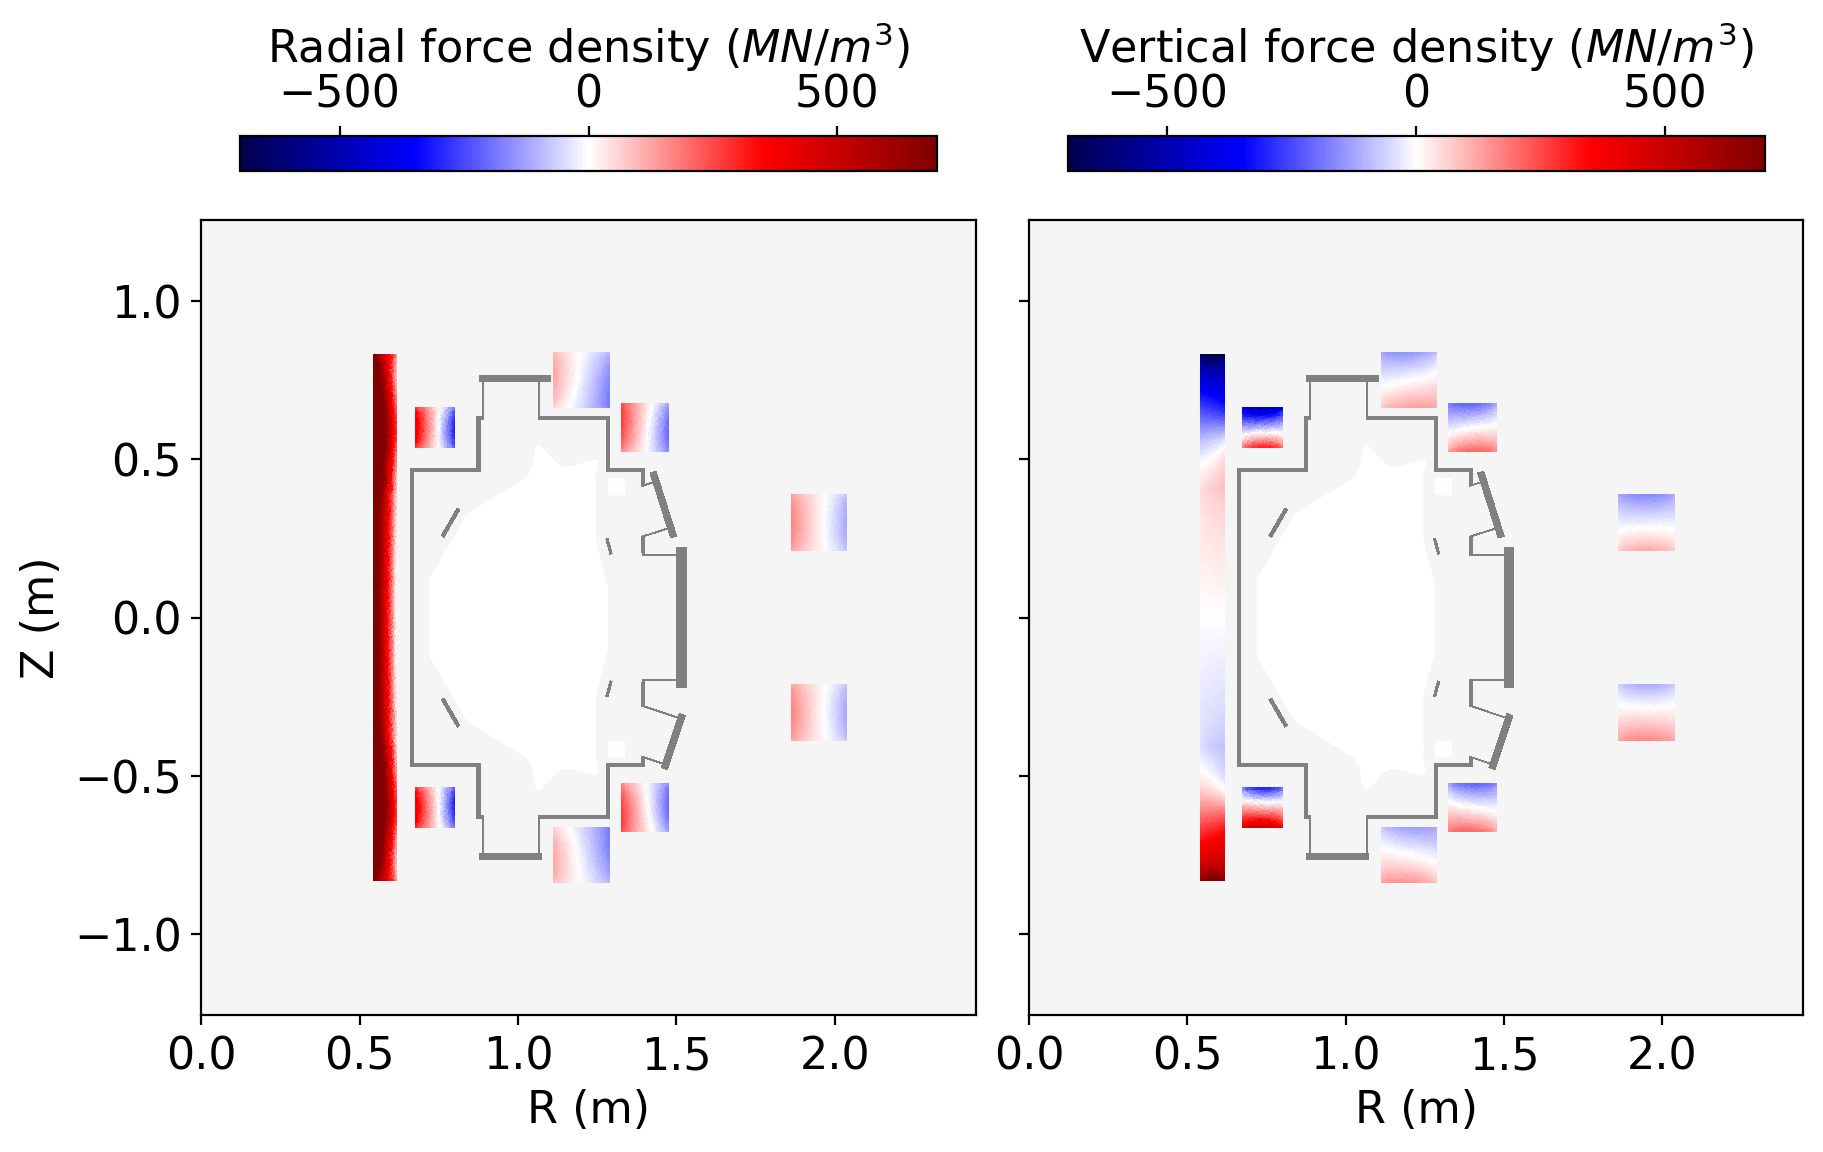

In [23]:
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(9,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R (m)')
#
clf = ax[0].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6,cmap='seismic',vmax=700,vmin=-700)#,vmax=300)
fig.colorbar(clf,ax=ax[0],label=r'Radial force density ($MN/m^3$)', location='top', shrink=0.9)
# Toroidal force
clf = ax[1].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6,cmap='seismic',vmax=700,vmin=-700)
fig.colorbar(clf,ax=ax[1],label=r'Vertical force density ($MN/m^3$)', location='top', shrink=0.9)
_ = ax[0].set_ylabel('Z (m)')
fig.savefig('NTT_PF_forces.png',dpi=300)

## Case 3 (unused)

   1  1.9470E+05


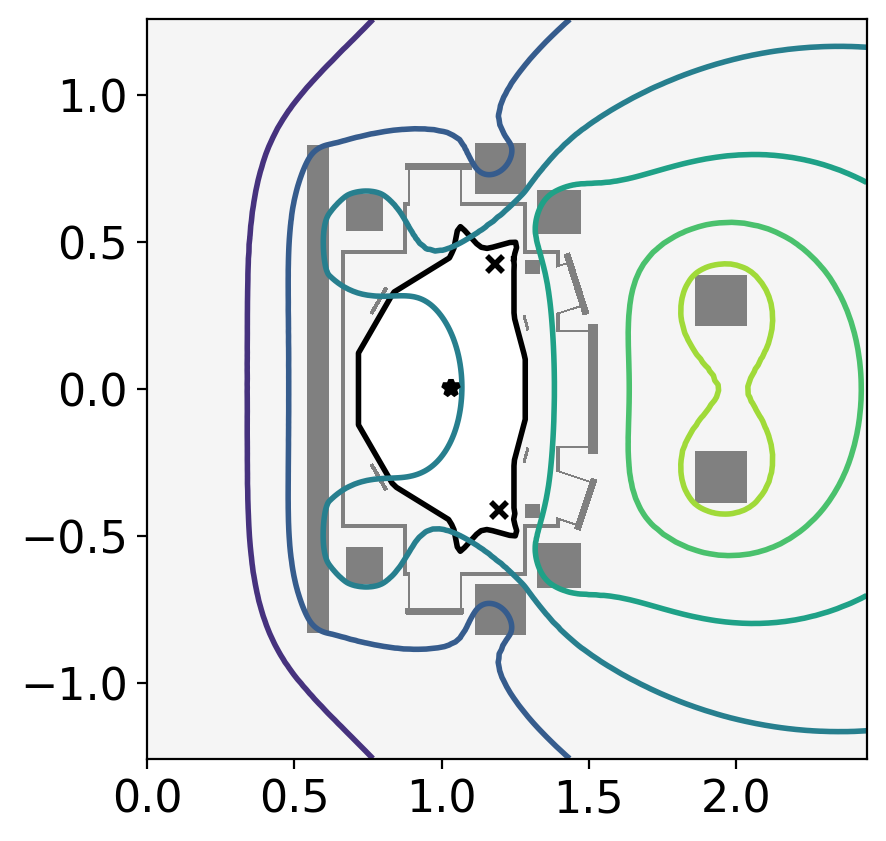

In [24]:
coil_currents = np.zeros((mygs.ncoils,), dtype=np.float64)

# CS coils
coil_currents[mygs.coil_sets['CS_1']['id']] = 3.5E6
coil_currents[mygs.coil_sets['CS_2']['id']] = 6E6
coil_currents[mygs.coil_sets['CS_3']['id']] = 3.5E6

# PF coils
coil_currents[mygs.coil_sets['PF_1U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_1L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_2U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_2L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_3U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_3L']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_4U']['id']] = 1.5E6
coil_currents[mygs.coil_sets['PF_4L']['id']] = 1.5E6

# Case 3: PF2 is in opposite direction
coil_currents[mygs.coil_sets['PF_2U']['id']] = -1.5E6
coil_currents[mygs.coil_sets['PF_2L']['id']] = -1.5E6

mygs.set_coil_currents(coil_currents)
mygs.set_psi(0.0*mygs.get_psi())
psi_coil, __ = mygs.vac_solve()
mygs.set_psi(psi_coil-psi_plasma)
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax, normalized = False)

### Get poloidal field
Field is stored as \[B_r, B_phi, B_z\]

In [25]:
field_eval = mygs.get_field_eval('B')
for i in range(tf_pts.shape[0]):
    B_TF[i,[0,2]] = field_eval.eval(tf_pts[i,:])[[0,2]]

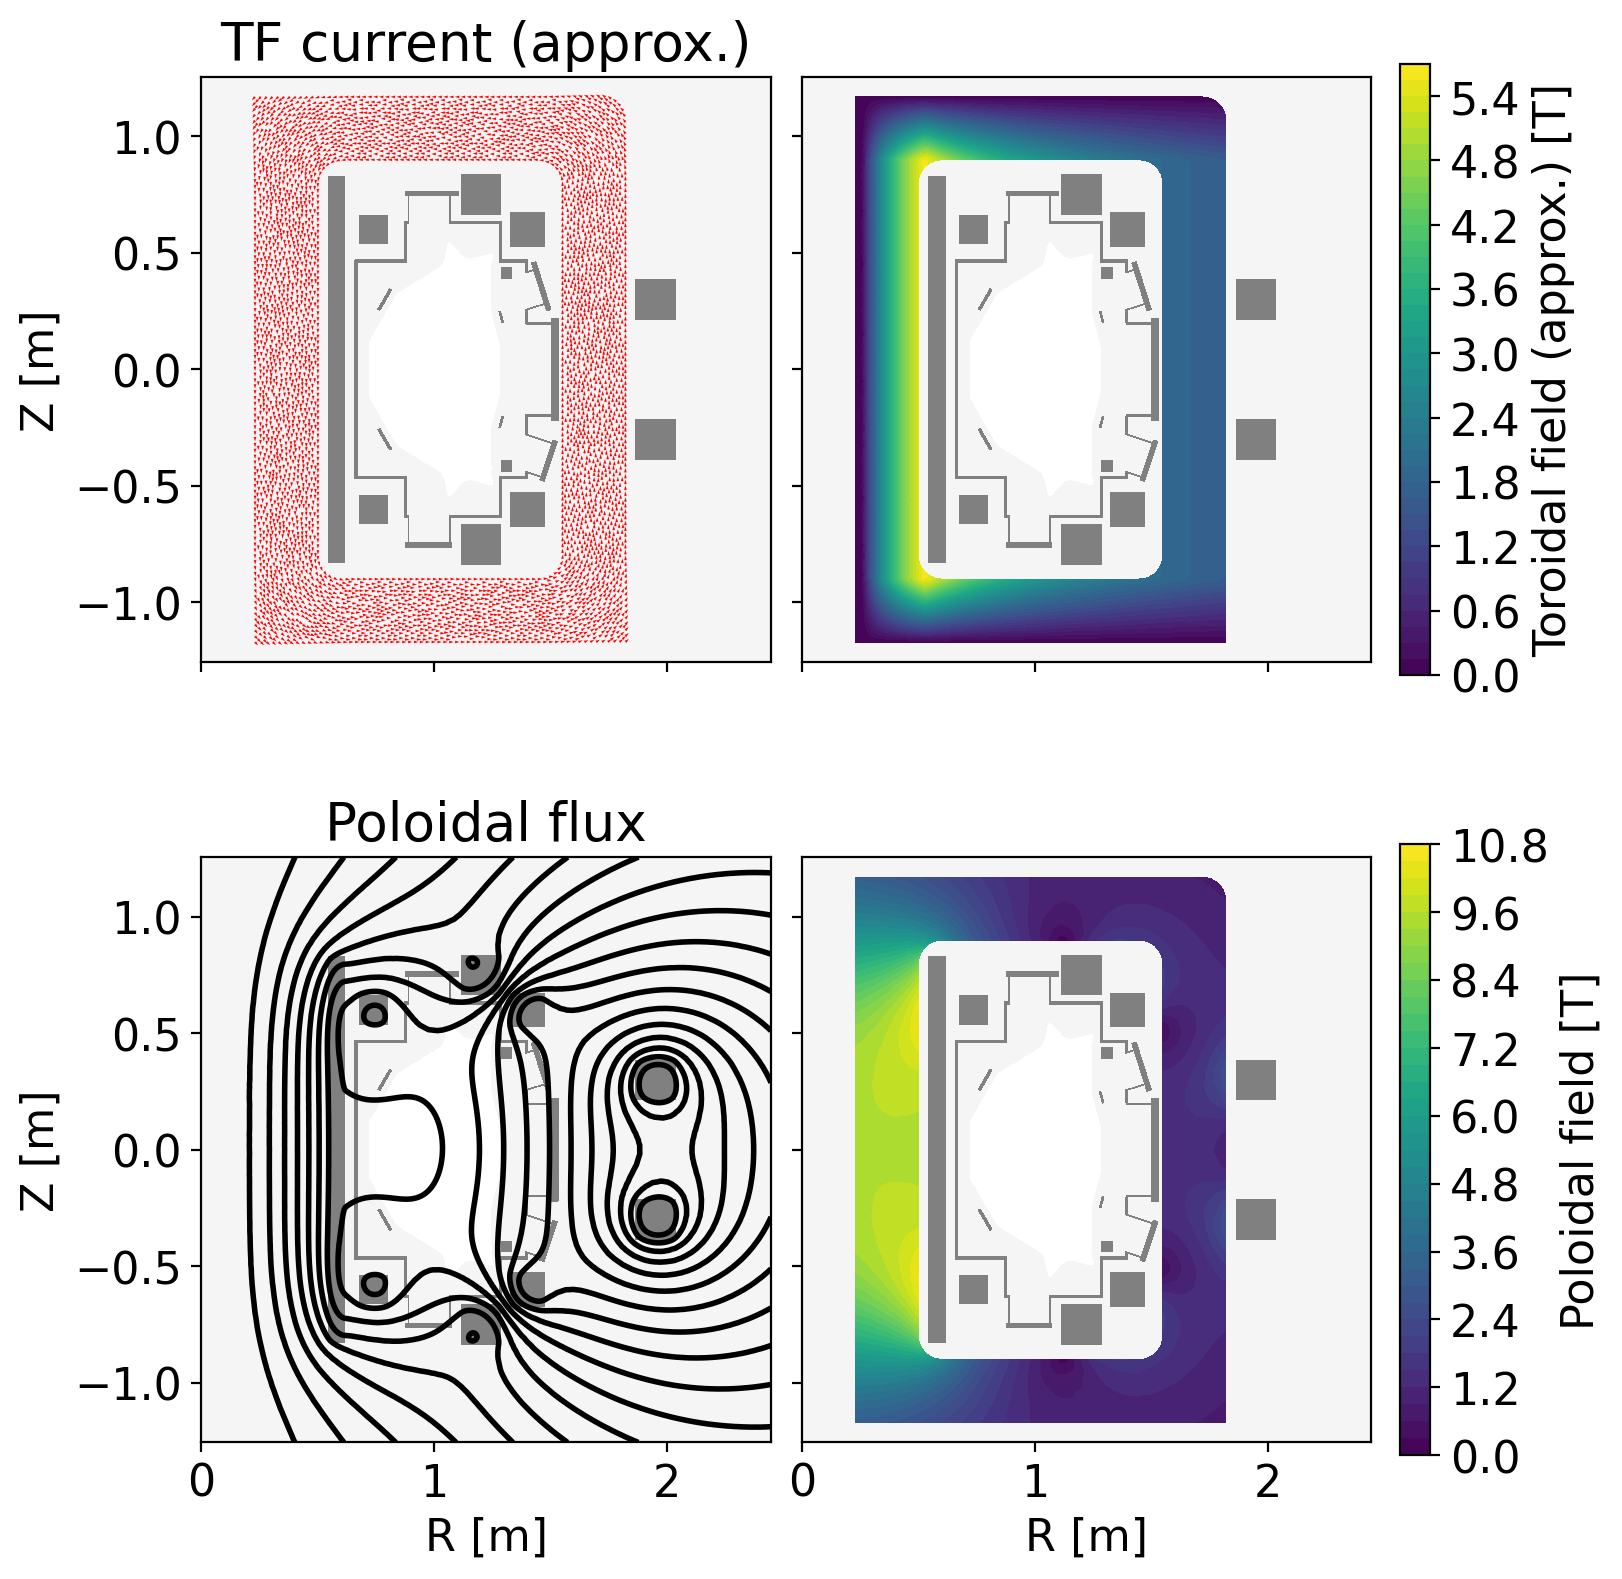

In [26]:
fig, ax = plt.subplots(2,2,sharey=True,sharex=True,figsize=(8,8),constrained_layout=True)
for ax_tmp in ax.flatten():
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
#
mygs.plot_psi(fig,ax[1,0],normalized=False,plasma_color='k',plasma_nlevels=20,opoint_color=None,xpoint_color=None)
ax[1,0].set_title('Poloidal flux')
clf = ax[1,1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,np.sqrt(np.power(B_TF[:,0],2)+np.power(B_TF[:,2],2)),40)
fig.colorbar(clf,ax=ax[1,1],label='Poloidal field [T]',shrink=0.8)
#
clf = ax[0,0].quiver(tf_pts[:,0],tf_pts[:,1],J_TF[:,0],J_TF[:,2],color='r')
ax[0,0].set_title('TF current (approx.)')
clf = ax[0,1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,1],40)
fig.colorbar(clf,ax=ax[0,1],label='Toroidal field (approx.) [T]',shrink=0.8)
#
ax[0,0].set_ylabel('Z [m]')
ax[1,0].set_ylabel('Z [m]')
ax[1,0].set_xlabel('R [m]')
_ = ax[1,1].set_xlabel('R [m]')

### Compute forces on TF coil (per coil)
Pressure is J_r * B_z * leg_thickness

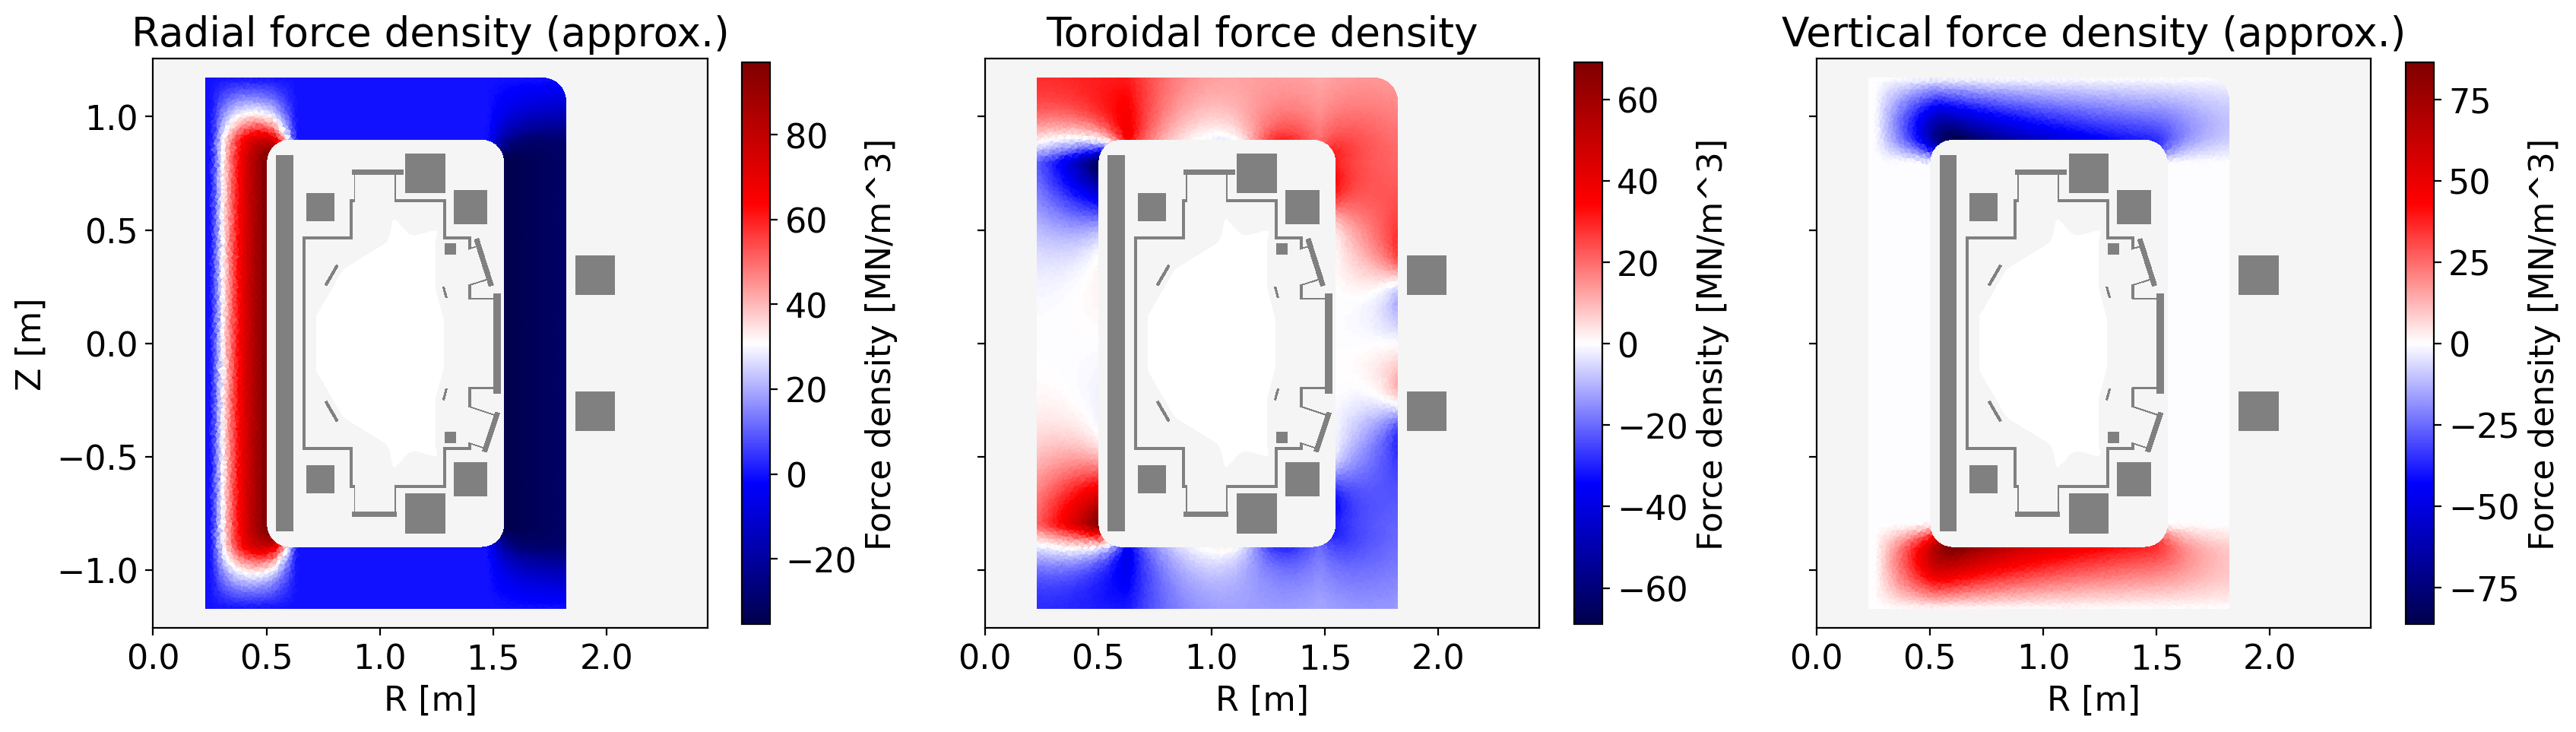

In [27]:
JxB = np.cross(J_TF,B_TF,axis=1)
# Radial
fig, ax = plt.subplots(1,3,sharey=True,figsize=(20,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R [m]')
clf = ax[0].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,0]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[0],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[0].set_title('Radial force density (approx.)')
# Toroidal force
clf = ax[1].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,1]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[1],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[1].set_title('Toroidal force density')
# Vertical
clf = ax[2].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,2]/1.E6,cmap='seismic')#,shading='gouraud')
fig.colorbar(clf,ax=ax[2],label='Force density [MN/m^3]',shrink=0.8)
_ = ax[2].set_title('Vertical force density (approx.)')
_ = ax[0].set_ylabel('Z [m]')

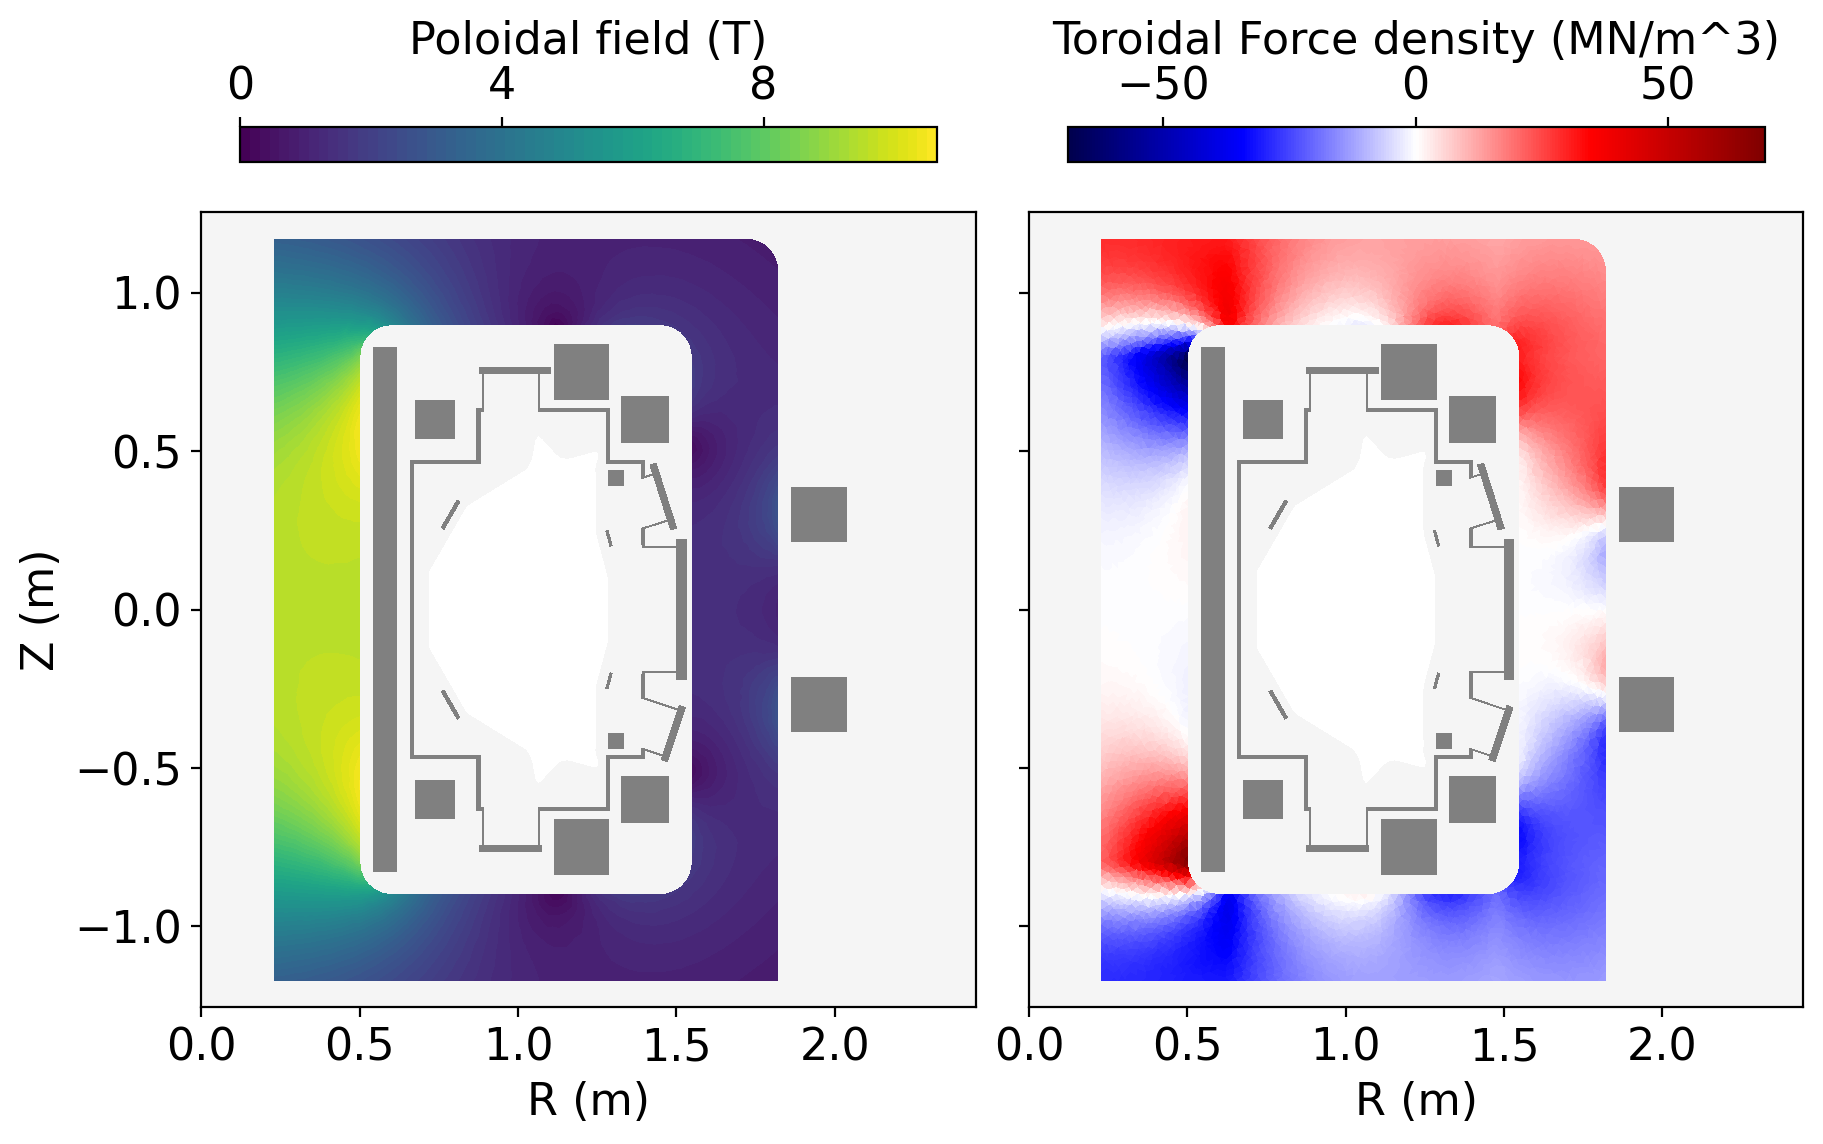

In [28]:
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(9,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R (m)')
#
clf = ax[0].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,np.sqrt(np.power(B_TF[:,0],2)+np.power(B_TF[:,2],2)),80)
fig.colorbar(clf,ax=ax[0],label='Poloidal field (T)',location='top',shrink=0.9,ticks=[0.0,4.0,8.0,12.0])
# Toroidal force
clf = ax[1].tripcolor(tf_pts[:,0],tf_pts[:,1],tf_lc,JxB[:,1]/1.E6,cmap='seismic')#,shading='gouraud')
_ = fig.colorbar(clf,ax=ax[1],label='Toroidal Force density (MN/m^3)',location='top',shrink=0.9)
_ = ax[0].set_ylabel('Z (m)')

In [29]:
overturning_force = 0.0
overturning_moment = 0.0
v1 = np.zeros((3,))
v2 = np.zeros((3,))
for i in range(tf_lc.shape[0]):
    v1[:-1] = tf_pts[tf_lc[i,1],:]-tf_pts[tf_lc[i,0],:]
    v2[:-1] = tf_pts[tf_lc[i,2],:]-tf_pts[tf_lc[i,0],:]
    area = np.linalg.norm(np.cross(v1,v2))/2.0
    rcc = (tf_pts[tf_lc[i,2],:]+tf_pts[tf_lc[i,1],:]+tf_pts[tf_lc[i,0],:])/3.0
    # Compute force on cell
    Favg = (JxB[tf_lc[i,2],1]+JxB[tf_lc[i,1],1]+JxB[tf_lc[i,0],1])/3.0
    overturning_force += np.sign(rcc[1])*area*Favg*leg_thickness
    overturning_moment += rcc[1]*area*Favg*leg_thickness
print('Overturning force per half coil = {0:10.2F} [kN] {1:10.2F} [T]'.format(abs(overturning_force)/2.0/1.E3,abs(overturning_force)/2.0*0.224809/2.E3))
print('Overturning moment per coil     = {0:10.2F} [kN-m]'.format(abs(overturning_moment)/1.E3))

Overturning force per half coil =    1472.53 [kN]     165.52 [T]
Overturning moment per coil     =    3041.48 [kN-m]


### Compute forces on PF coils

In [30]:
coil_currents, reg_currents = mygs.get_coil_currents()
B_PF = np.zeros((mesh_pts.shape[0],3))
F_PF = np.zeros((mesh_lc.shape[0],2))
F_PF[:] = np.nan
pt_mask = np.zeros((mesh_pts.shape[0],), dtype=np.int32)
for key, coil in coil_dict.items():
    pt_mask[mesh_lc[mesh_reg==coil['reg_id'],:]] = 1
for i in range(mesh_pts.shape[0]):
    if pt_mask[i] == 0:
        continue
    B_PF[i,:] = field_eval.eval(mesh_pts[i,:])
v1 = np.zeros((3,))
v2 = np.zeros((3,))
for key, coil in mygs.coil_sets.items():
    coil_area = 0.0
    coil_force = np.array([0.0,0.0])
    for subcoil in coil['sub_coils']:
        subcoil_area = 0.0
        nc = np.sum(mesh_reg==subcoil['reg_id'])
        Bcc = np.zeros((nc,3))
        for i, lc in enumerate(mesh_lc[mesh_reg==subcoil['reg_id'],:]):
            v1[:2] = mesh_pts[lc[1],:]-mesh_pts[lc[0],:]
            v2[:2] = mesh_pts[lc[2],:]-mesh_pts[lc[0],:]
            area = np.linalg.norm(np.cross(v1,v2))/2.0
            rcc = (mesh_pts[lc[2],:]+mesh_pts[lc[1],:]+mesh_pts[lc[0],:])/3.0
            Bcc[i,:] = (B_PF[lc[2],:]+B_PF[lc[1],:]+B_PF[lc[0],:])/3.0
            coil_force += Bcc[i,[2,0]]*reg_currents[subcoil['reg_id']-1]*area*2.0*np.pi*rcc[0]
            subcoil_area += area
        coil_area += subcoil_area
        Jtor_subcoil = coil_currents[coil['id']]*subcoil['nturns']/subcoil_area
        F_PF[mesh_reg==subcoil['reg_id'],0] = Bcc[:,2]*Jtor_subcoil
        F_PF[mesh_reg==subcoil['reg_id'],1] = -Bcc[:,0]*Jtor_subcoil
    coil_force /= coil_area
    print('{0:4} {1:14.4E} {2:14.4E}'.format(key,coil_force[0],-coil_force[1]))

CS_1     6.9835E+07    -2.7406E+07
CS_2     1.0574E+08    -5.3847E+04
CS_3     6.9915E+07     2.7439E+07
PF_1U     1.3763E+06    -1.0119E+07
PF_1L     1.4149E+06     1.0155E+07
PF_2U    -1.4915E+07     1.8353E+07
PF_2L    -1.4903E+07    -1.8378E+07
PF_3U     2.3116E+07    -1.7560E+07
PF_3L     2.3093E+07     1.7560E+07
PF_4U     4.9166E+06    -9.0865E+06
PF_4L     4.9145E+06     9.0738E+06
DIV_U     0.0000E+00    -0.0000E+00
DIV_L     0.0000E+00    -0.0000E+00


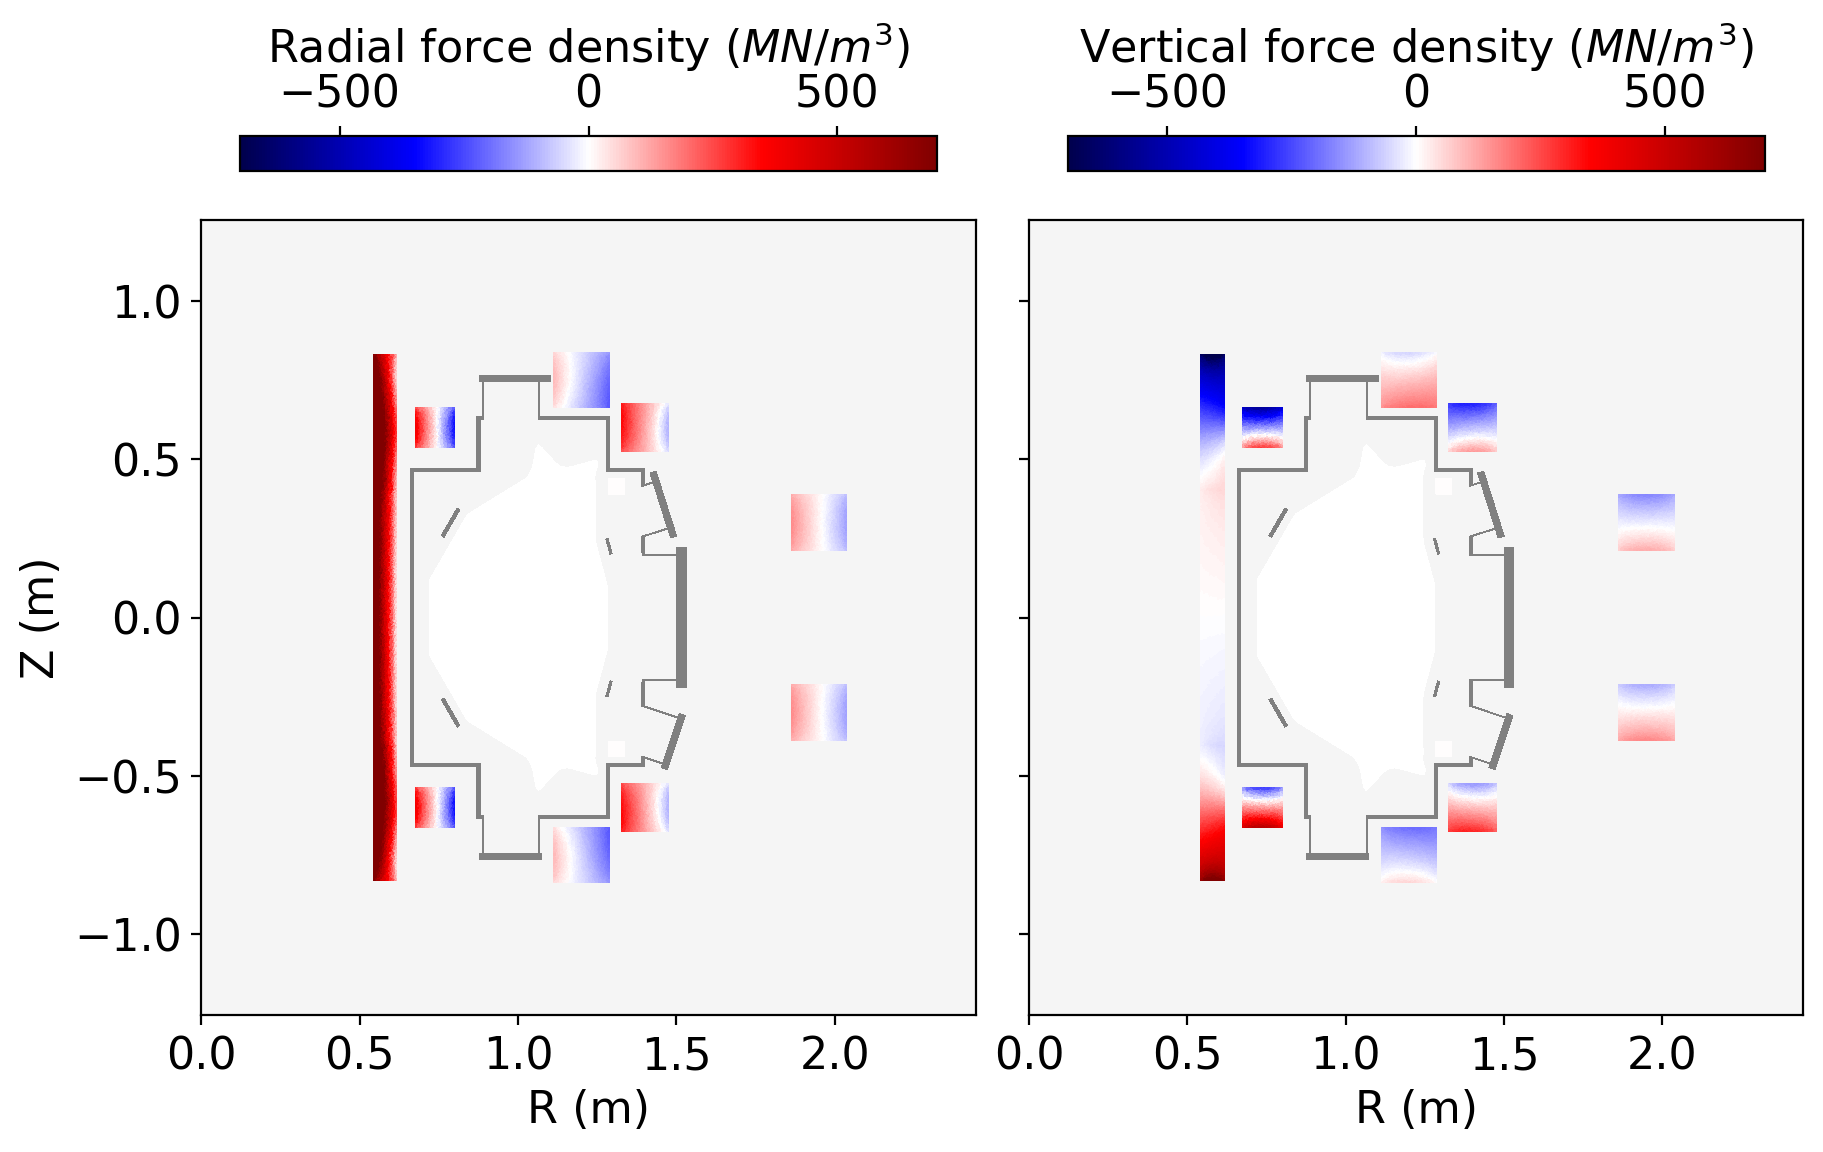

In [31]:
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(9,6))
for ax_tmp in ax:
    mygs.plot_machine(fig,ax_tmp,limiter_color=None)
    ax_tmp.set_xlabel('R (m)')
#
clf = ax[0].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6,cmap='seismic',vmax=700,vmin=-700)#,vmax=300)
fig.colorbar(clf,ax=ax[0],label=r'Radial force density ($MN/m^3$)', location='top', shrink=0.9)
# Toroidal force
clf = ax[1].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6,cmap='seismic',vmax=700,vmin=-700)
fig.colorbar(clf,ax=ax[1],label=r'Vertical force density ($MN/m^3$)', location='top', shrink=0.9)
_ = ax[0].set_ylabel('Z (m)')